<a href="https://www.kaggle.com/code/mukterhosain/heartbeat-sound-analysis?scriptVersionId=256839345" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

from keras.utils import np_utils
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [2]:
data_path = "../input/heartbeat-sound/Heartbeat_Sound/"
print(os.listdir(data_path))

['artifact', 'unlabel', 'extrastole', 'extrahls', 'normal', 'murmur']


In [3]:
tarin_data      = data_path 
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [4]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds 
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds 
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds 
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds 

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data)) 
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [5]:
print("No. of Sample for Test sounds: ", len(os.listdir(unlabel_data)))

No. of Sample for Test sounds:  247


# EDA and Visualization

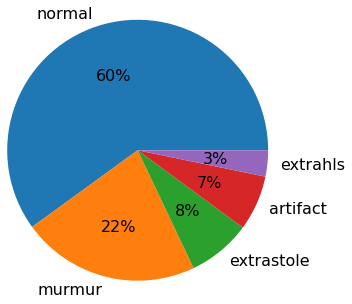

In [6]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

##### The figure shows imbalanced data so we need to fix it later 


In [7]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class))) 
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

In [8]:
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveplot(audio_sample, sr = 22050)
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [9]:
# show spectrum of audio from dataset 
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [10]:
def show_spectrogram (audio_sample):    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

### MFCCs

In [11]:
def show_mfcc_features(audio_sample):
    hop_length = 512 
    n_fft = 2048 
    sample_rate = 22050
    
    MFCCs = librosa.feature.mfcc(audio_sample, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)

    # display MFCCs
    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

##  Dataset Classes

### *1. Normal* 

In [12]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

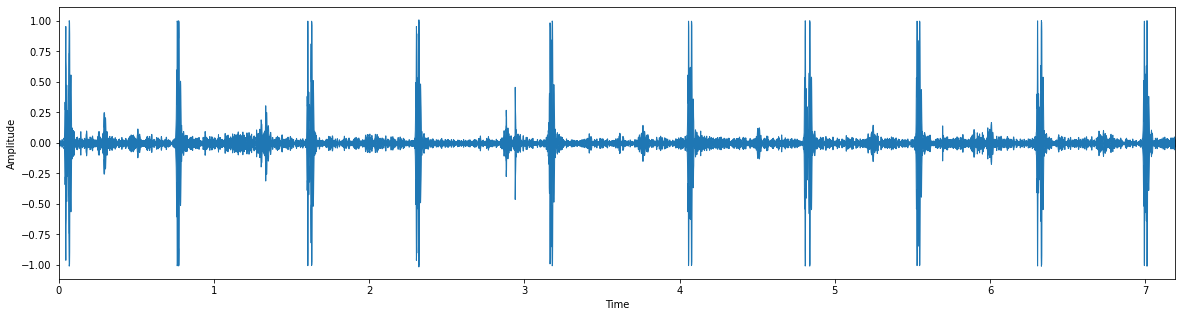

In [13]:
show_audio_waveform(normal_sample)

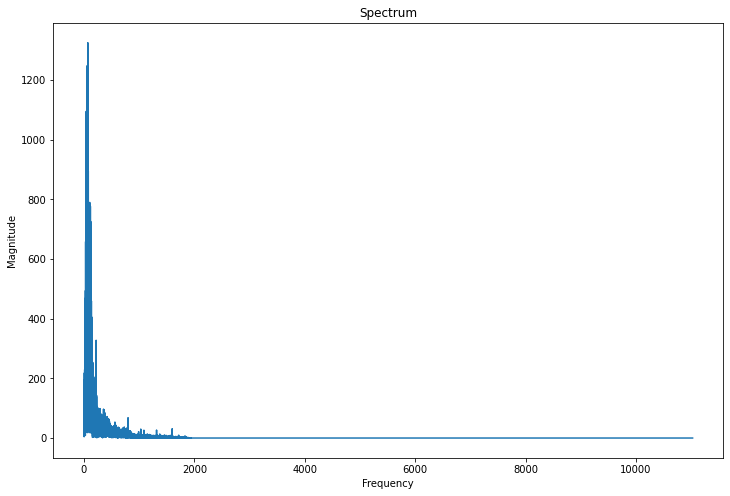

In [14]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


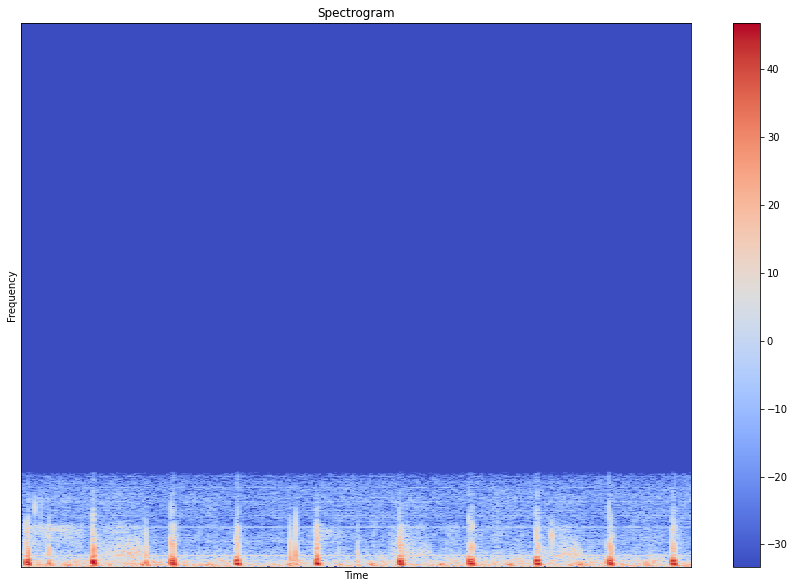

In [15]:
show_spectrogram(normal_sample)

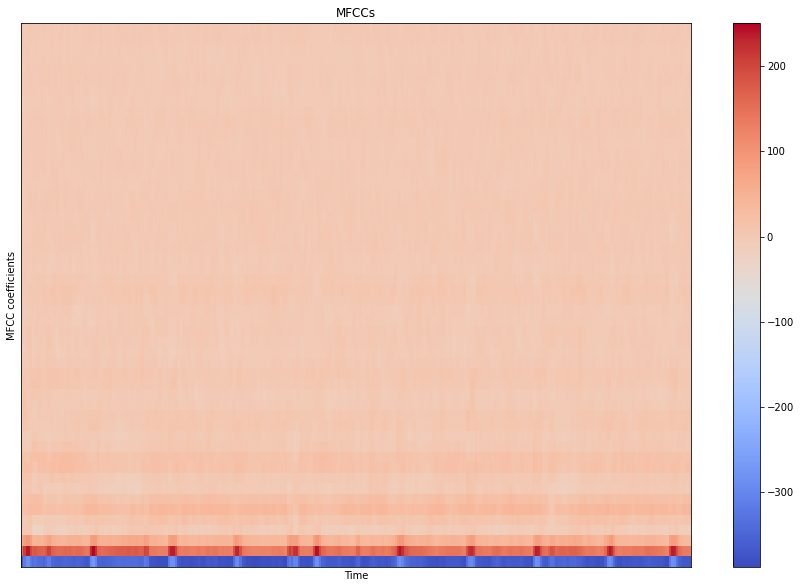

In [16]:
show_mfcc_features(normal_sample)

### *2. Murmur sound*

In [17]:
murmur_audio, murmur_sample  = random_sound(murmur_data)
murmur_audio

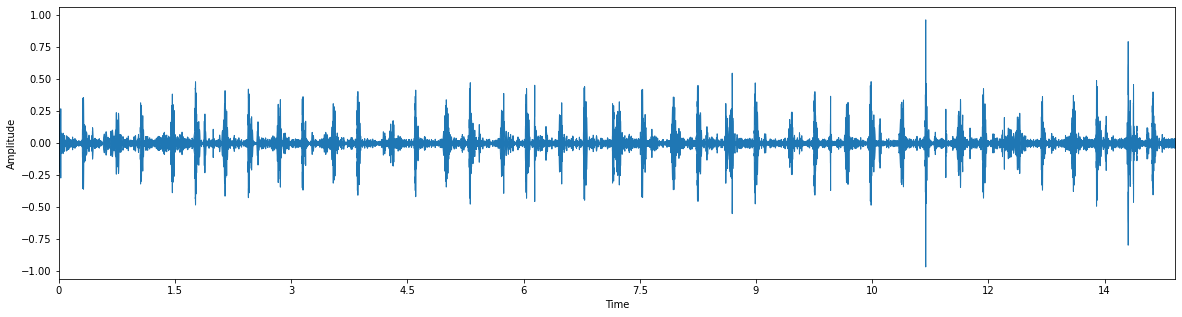

In [18]:
show_audio_waveform(murmur_sample)

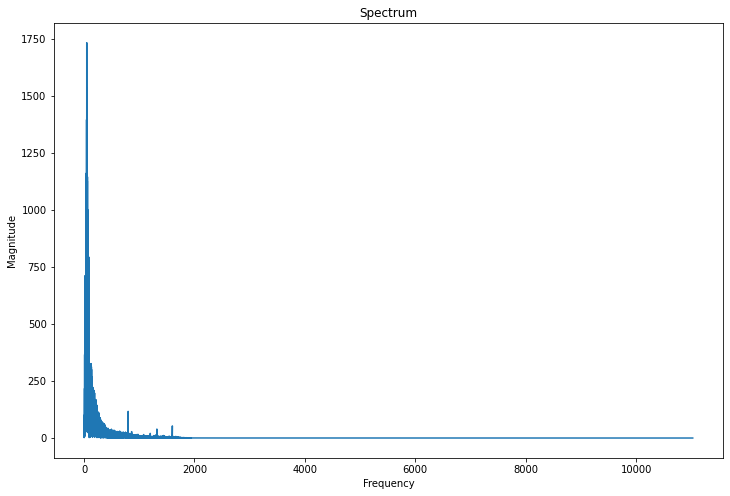

In [19]:
show_audio_spectrum(murmur_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


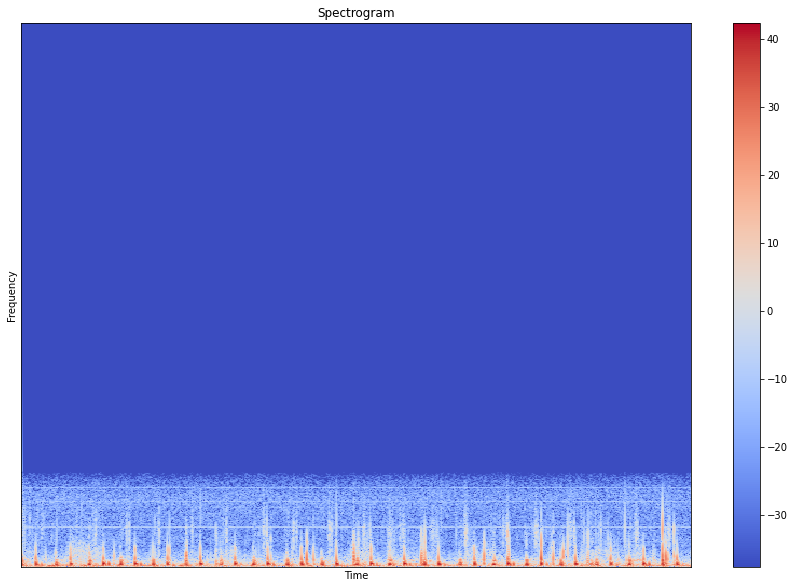

In [20]:
show_spectrogram(murmur_sample)

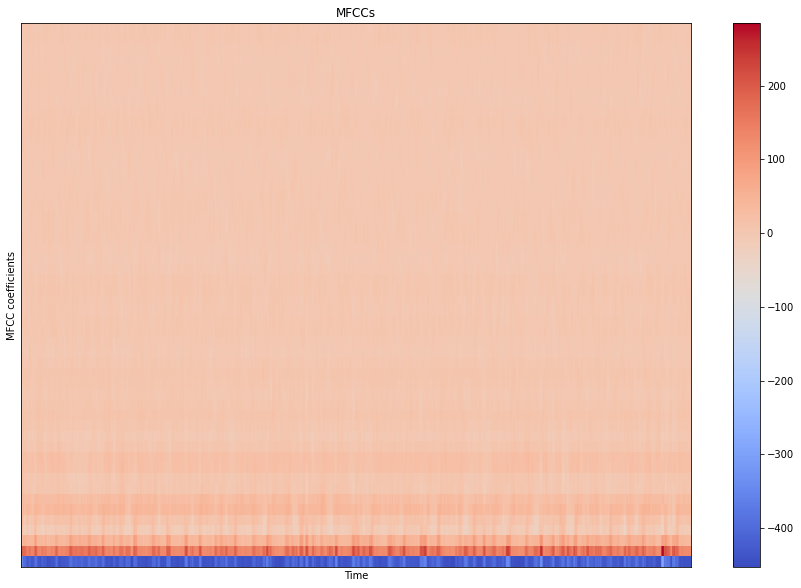

In [21]:
show_mfcc_features(murmur_sample)

### *3. Extrastole sound*

In [22]:
extrastole_audio, extrastole_sample  = random_sound(extrastole_data)
extrastole_audio

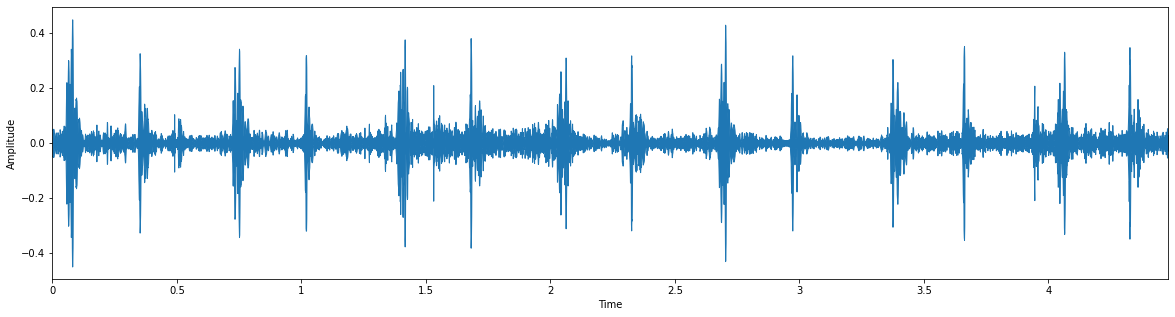

In [23]:
show_audio_waveform(extrastole_sample)

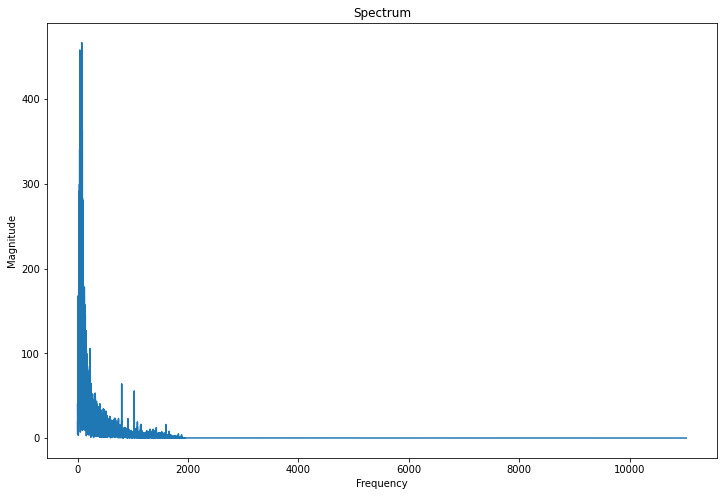

In [24]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


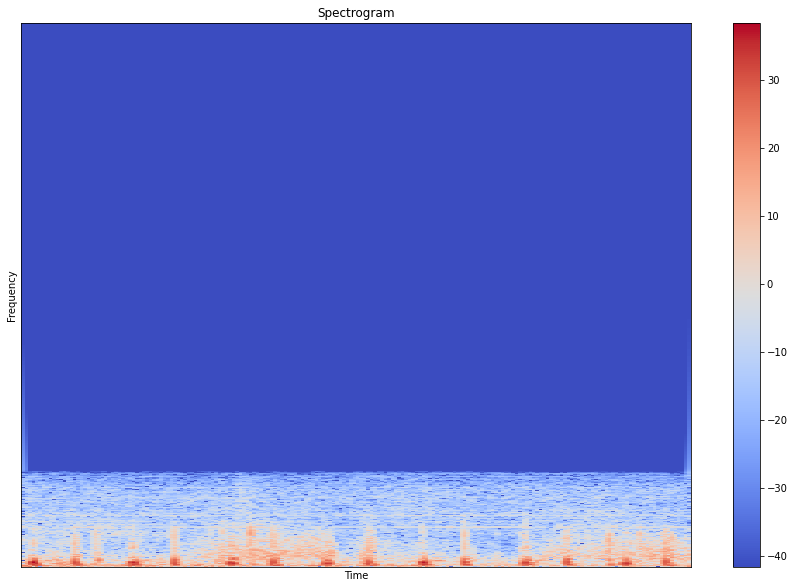

In [25]:
show_spectrogram(extrastole_sample)

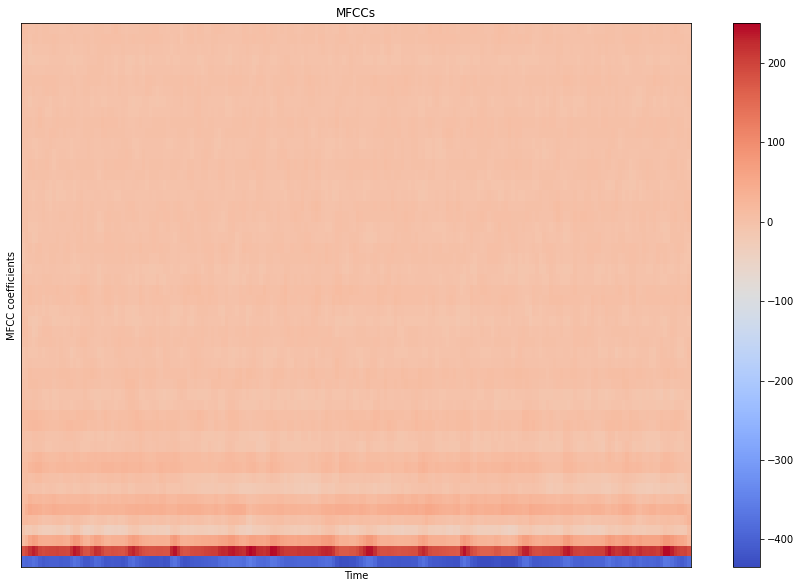

In [26]:
show_mfcc_features(extrastole_sample)

### *4. Artifact sound*

In [27]:
artifact_audio, artifact_sample  = random_sound(artifact_data)
artifact_audio

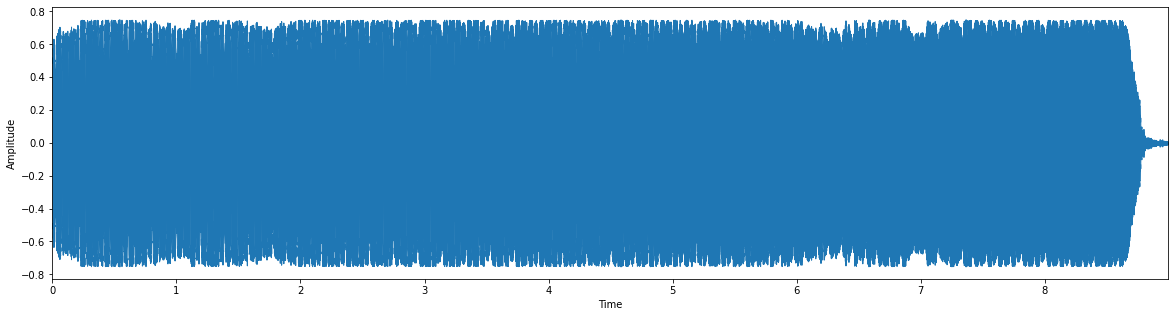

In [28]:
show_audio_waveform(artifact_sample)

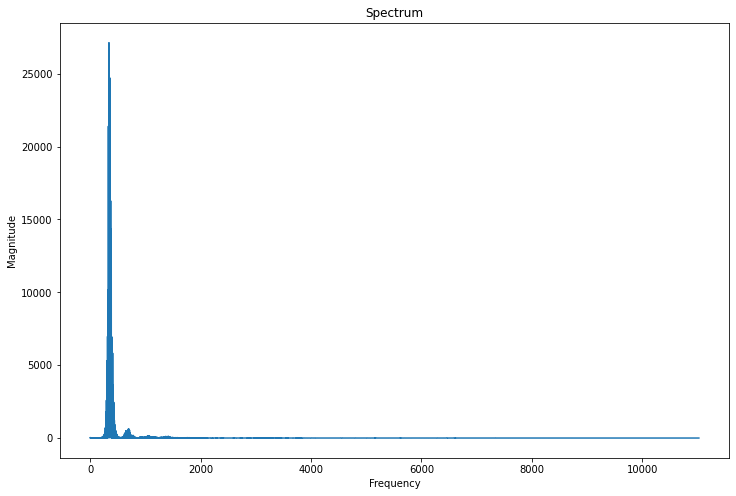

In [29]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


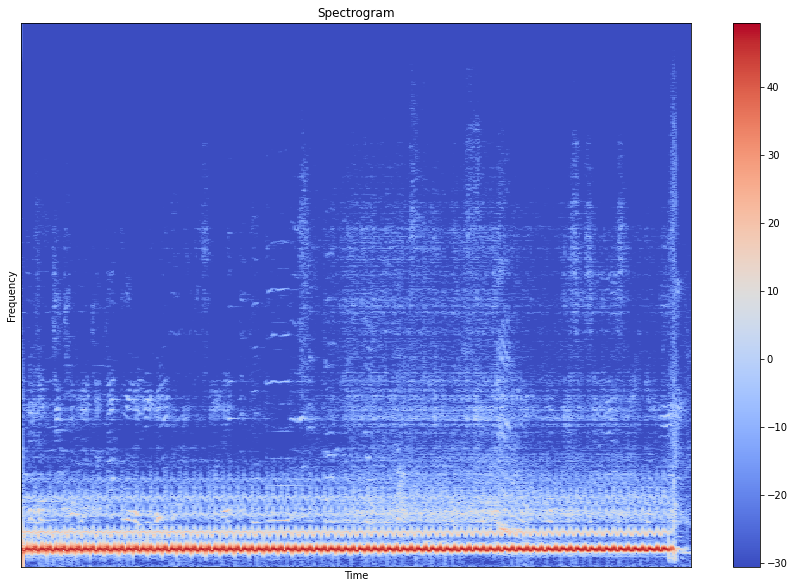

In [30]:
show_spectrogram(artifact_sample)

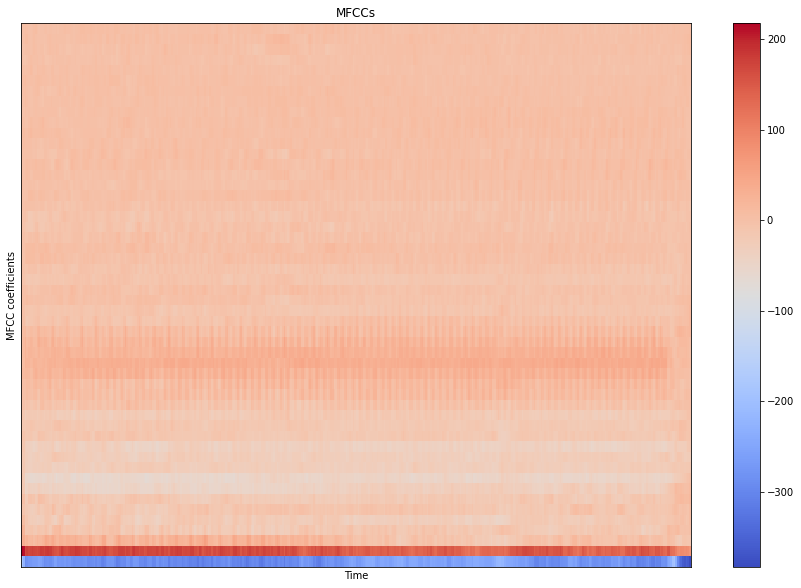

In [31]:
show_mfcc_features(artifact_sample)

### *5. Extrahls sound*

In [32]:
extrahls_audio, extrahls_sample  = random_sound(extrahls_data)
extrahls_audio

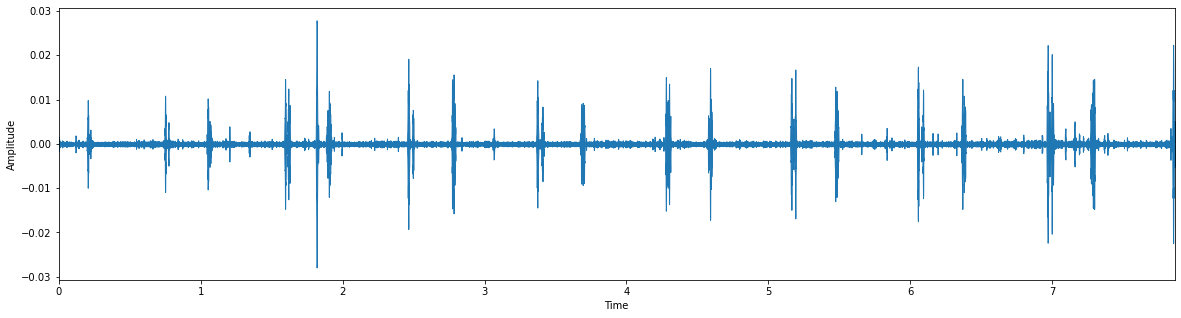

In [33]:
show_audio_waveform(extrahls_sample)

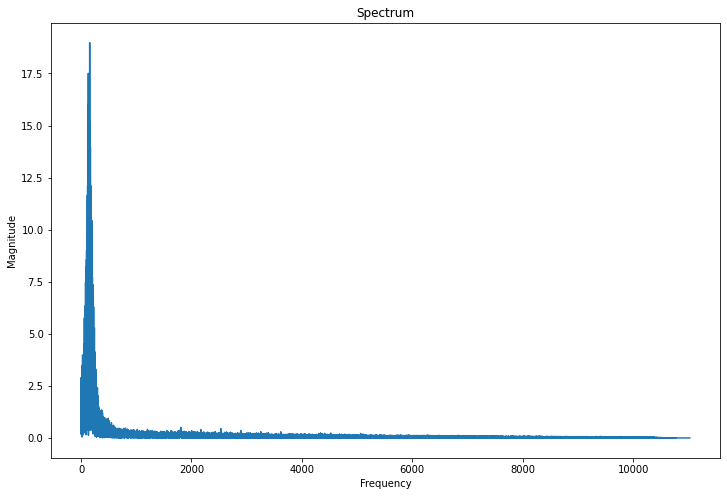

In [34]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


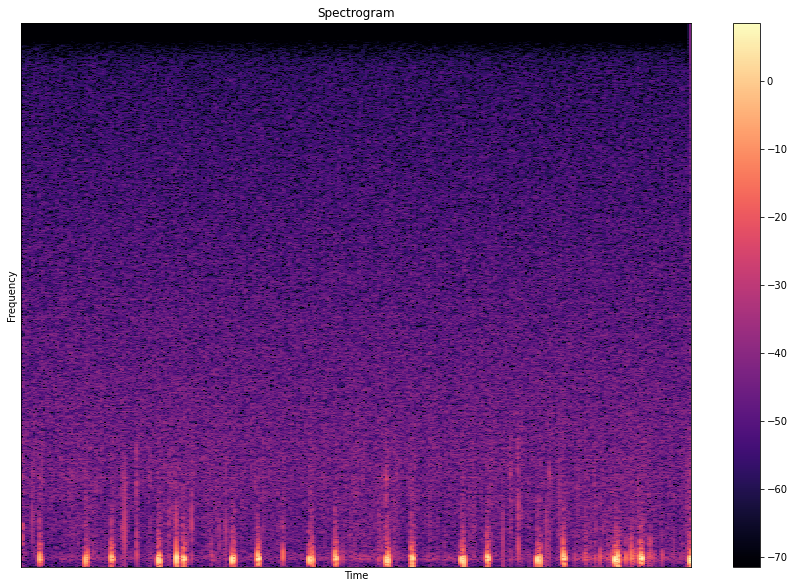

In [35]:
show_spectrogram(extrahls_sample)

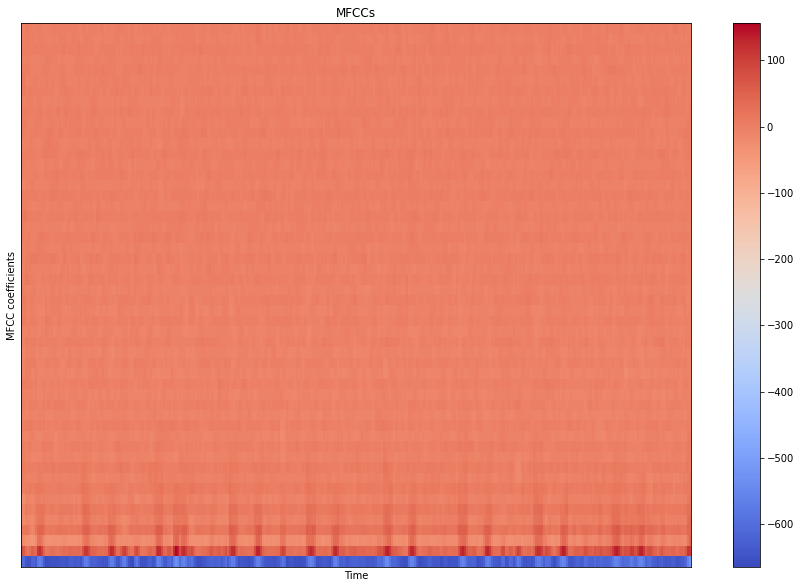

In [36]:
show_mfcc_features(extrahls_sample)

# Data Preprocessing

In [37]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [38]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, input_length)  
                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0) 
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
            
            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0) 
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)
            
            stretch_data_2 = stretch (X, 1.2) 
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0) 
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)
            
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        
    return data

## Encoding

In [39]:
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Data Augmenation and Feature Extraction

In [40]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data, file_names = artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")


fixing audio lenght : artifact__201106131834.wav
fixing audio lenght : artifact__201106101955.wav
fixing audio lenght : artifact__201106220340.wav
fixing audio lenght : artifact__201105190800.wav
fixing audio lenght : artifact__201106040722.wav
fixing audio lenght : artifact__201106070949.wav
fixing audio lenght : artifact__201106221254.wav
fixing audio lenght : artifact__201106010602.wav
fixing audio lenght : artifact__201106021541.wav
fixing audio lenght : artifact__201106010559.wav
fixing audio lenght : artifact__201105061143.wav
fixing audio lenght : artifact__201106110909.wav
fixing audio lenght : artifact__201106161219.wav
fixing audio lenght : artifact__201105040918.wav
fixing audio lenght : artifact__201106211041.wav
fixing audio lenght : artifact__201106211430.wav
fixing audio lenght : artifact__201105280851.wav
fixing audio lenght : artifact__201105051017.wav
fixing audio lenght : artifact__201106131835.wav
fixing audio lenght : artifact__201106050353.wav
fixing audio lenght 

In [41]:
# unlabel_data files conversion
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")


fixing audio lenght : Bunlabelledtest__231_1308748318393_C.wav
fixing audio lenght : Bunlabelledtest__152_1306779561195_C.wav
fixing audio lenght : Bunlabelledtest__235_1308749032454_C1.wav
fixing audio lenght : Bunlabelledtest__107_1305654946865_B.wav
fixing audio lenght : Bunlabelledtest__148_1306768801551_D.wav
fixing audio lenght : Bunlabelledtest__171_1307971016233_F.wav
fixing audio lenght : Bunlabelledtest__169_1307970398039_C1.wav
fixing audio lenght : Bunlabelledtest__148_1306768801551_A.wav
fixing audio lenght : Bunlabelledtest__179_1307990076841_D1.wav
fixing audio lenght : Bunlabelledtest__159_1307018640315_C.wav
fixing audio lenght : Bunlabelledtest__300_1311772096120_D.wav
fixing audio lenght : Bunlabelledtest__151_1306779785624_A1.wav
fixing audio lenght : Bunlabelledtest__181_1308052613891_C.wav
fixing audio lenght : Bunlabelledtest__174_1307987737137_C.wav
fixing audio lenght : Bunlabelledtest__286_1311170606028_B.wav
fixing audio lenght : Bunlabelledtest__175_13079879

## Concatenation

In [42]:
#combine set-a and set-b 
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))
print(x_data)
y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(x_data), len(test_x))

[[[-3.40292053e+02]
  [ 1.31745560e+02]
  [ 2.89621391e+01]
  ...
  [ 3.16183835e-01]
  [-4.91125613e-01]
  [-6.36102438e-01]]

 [[-3.52169678e+02]
  [ 1.22120880e+02]
  [ 3.10026417e+01]
  ...
  [-5.31147979e-02]
  [-8.96321535e-01]
  [-1.15266137e-01]]

 [[-3.54360382e+02]
  [ 1.29815430e+02]
  [ 3.05948925e+01]
  ...
  [ 1.83130540e-02]
  [-1.31864154e+00]
  [-6.76173806e-01]]

 ...

 [[-4.09144836e+02]
  [ 9.89138718e+01]
  [ 3.90294380e+01]
  ...
  [-6.19691372e-01]
  [ 2.71625698e-01]
  [ 2.90518343e-01]]

 [[-4.32297424e+02]
  [ 9.59234848e+01]
  [ 4.02707481e+01]
  ...
  [-8.64639163e-01]
  [ 3.65361311e-02]
  [ 2.60697812e-01]]

 [[-4.44941559e+02]
  [ 1.02441124e+02]
  [ 4.15524025e+01]
  ...
  [-9.18059647e-01]
  [ 2.54658103e-01]
  [ 3.98600131e-01]]]
combined training data record:  1755 741


## Data Split


In [43]:
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot Encoding

y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

## Correct Imbalanced Data

In [44]:
# class weight 
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

## confusion matrix, classification report, loss & accuracy curve function

In [45]:
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_saved_model(model_name, epoch):
    # Load y_true & y_pred
    y_true_file = f"{model_name}_ytrue_{epoch}epochs.npy"
    y_pred_file = f"{model_name}_ypred_{epoch}epochs.npy"
    history_file = f"{model_name}_history_{epoch}epochs.pkl"
    
    y_true = np.argmax(np.load(y_true_file), axis=1)
    y_pred = np.argmax(np.load(y_pred_file), axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name.upper()} Confusion Matrix ({epoch} epochs)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Classification report
    print(f"\n{model_name.upper()} Classification Report ({epoch} epochs):\n")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Load history
    with open(history_file, "rb") as f:
        history = pickle.load(f)
    
    # Plot Loss & Accuracy Curve
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"{model_name.upper()} Loss Curve ({epoch} epochs)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title(f"{model_name.upper()} Accuracy Curve ({epoch} epochs)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()


# Deep Learning Model

### 1. CNN

In [46]:
# ==== CNN ====
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old CNN files ====
for f in os.listdir():
    if f.startswith("cnn_") or f.startswith("cnn_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== CNN Model ====
cnn = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=(52,1)),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(3, activation='softmax')
])
cnn.compile(optimizer=Adamax(learning_rate=0.01),
            loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = cnn.fit(x_train,y_train,validation_data=(x_val,y_val),
                    epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(cnn,x_test,y_test,f"CNN after {target} epochs")
    cnn.save(f"cnn_model_{target}epochs.h5")
    pickle.dump(hist,open(f"cnn_history_{target}epochs.pkl","wb"))
    np.save(f"cnn_ypred_{target}epochs.npy",cnn.predict(x_test,verbose=0))
    np.save(f"cnn_ytrue_{target}epochs.npy",y_test)

print("\n✅ CNN Training complete.")



CNN after 50 epochs Performance:
Accuracy:0.9003 F1:0.8994 Recall:0.9003 Precision:0.8997

CNN after 100 epochs Performance:
Accuracy:0.9117 F1:0.9150 Recall:0.9117 Precision:0.9257

CNN after 150 epochs Performance:
Accuracy:0.9345 F1:0.9369 Recall:0.9345 Precision:0.9459

CNN after 200 epochs Performance:
Accuracy:0.8946 F1:0.8994 Recall:0.8946 Precision:0.9164

CNN after 250 epochs Performance:
Accuracy:0.9430 F1:0.9448 Recall:0.9430 Precision:0.9524

CNN after 300 epochs Performance:
Accuracy:0.9402 F1:0.9424 Recall:0.9402 Precision:0.9513

✅ CNN Training complete.


In [47]:
cnn_files = [f for f in os.listdir() if f.startswith("cnn_") or f.startswith("cnn_model_")]
print("Saved CNN files:\n")
for f in sorted(cnn_files):
    print(f)


Saved CNN files:

cnn_history_100epochs.pkl
cnn_history_150epochs.pkl
cnn_history_200epochs.pkl
cnn_history_250epochs.pkl
cnn_history_300epochs.pkl
cnn_history_50epochs.pkl
cnn_model_100epochs.h5
cnn_model_150epochs.h5
cnn_model_200epochs.h5
cnn_model_250epochs.h5
cnn_model_300epochs.h5
cnn_model_50epochs.h5
cnn_ypred_100epochs.npy
cnn_ypred_150epochs.npy
cnn_ypred_200epochs.npy
cnn_ypred_250epochs.npy
cnn_ypred_300epochs.npy
cnn_ypred_50epochs.npy
cnn_ytrue_100epochs.npy
cnn_ytrue_150epochs.npy
cnn_ytrue_200epochs.npy
cnn_ytrue_250epochs.npy
cnn_ytrue_300epochs.npy
cnn_ytrue_50epochs.npy


### 1.CNN confusion matrix, classification report, loss & accuracy curve

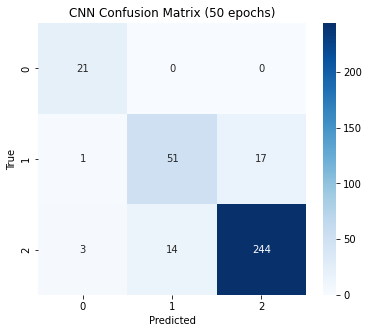


CNN Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.8400    1.0000    0.9130        21
           1     0.7846    0.7391    0.7612        69
           2     0.9349    0.9349    0.9349       261

    accuracy                         0.9003       351
   macro avg     0.8532    0.8913    0.8697       351
weighted avg     0.8997    0.9003    0.8994       351



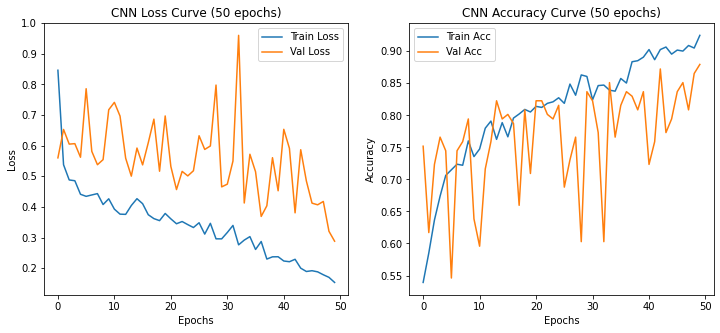

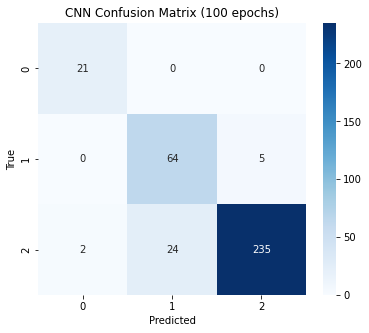


CNN Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.7273    0.9275    0.8153        69
           2     0.9792    0.9004    0.9381       261

    accuracy                         0.9117       351
   macro avg     0.8732    0.9426    0.9027       351
weighted avg     0.9257    0.9117    0.9150       351



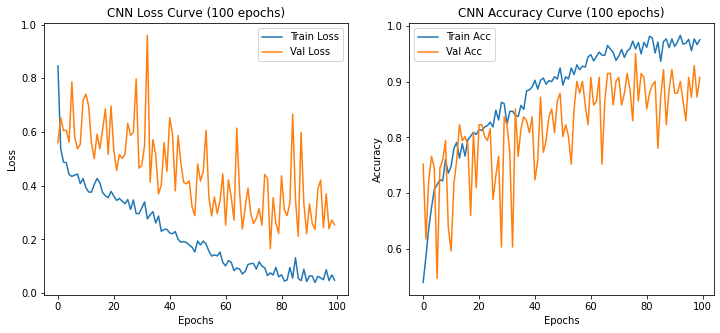

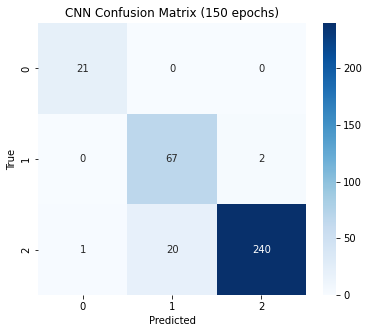


CNN Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7701    0.9710    0.8590        69
           2     0.9917    0.9195    0.9543       261

    accuracy                         0.9345       351
   macro avg     0.9055    0.9635    0.9300       351
weighted avg     0.9459    0.9345    0.9369       351



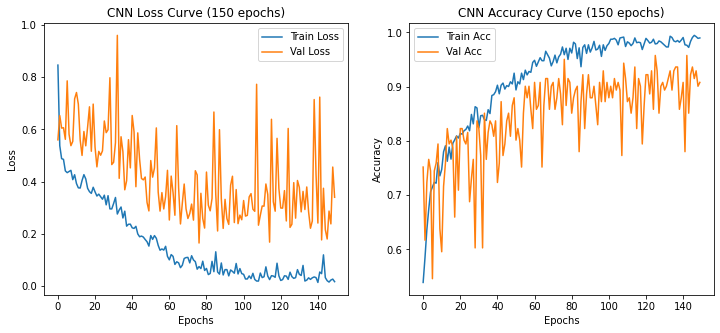

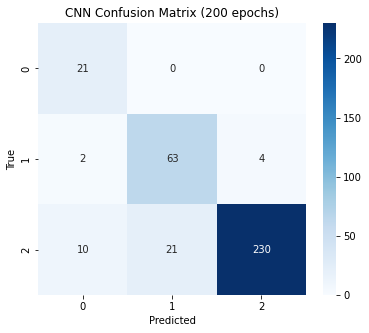


CNN Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     0.6364    1.0000    0.7778        21
           1     0.7500    0.9130    0.8235        69
           2     0.9829    0.8812    0.9293       261

    accuracy                         0.8946       351
   macro avg     0.7898    0.9314    0.8435       351
weighted avg     0.9164    0.8946    0.8994       351



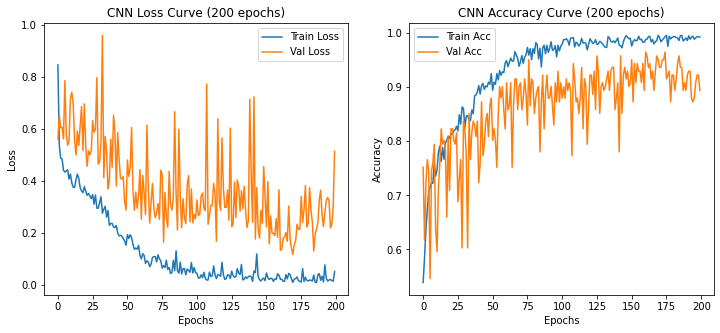

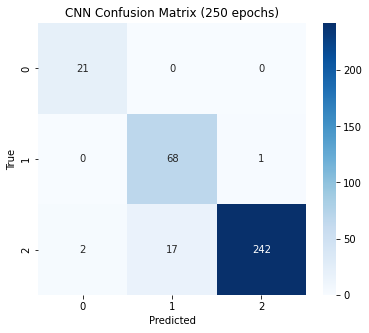


CNN Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.8000    0.9855    0.8831        69
           2     0.9959    0.9272    0.9603       261

    accuracy                         0.9430       351
   macro avg     0.9030    0.9709    0.9327       351
weighted avg     0.9524    0.9430    0.9448       351



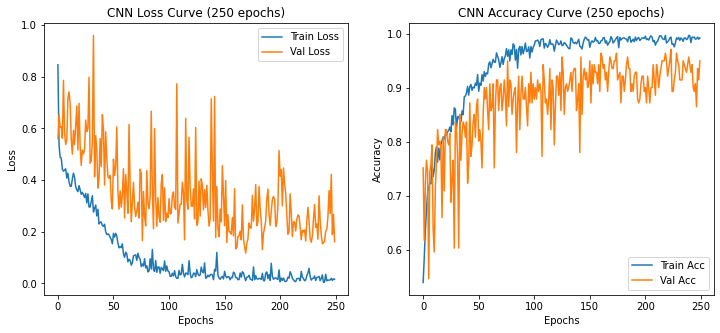

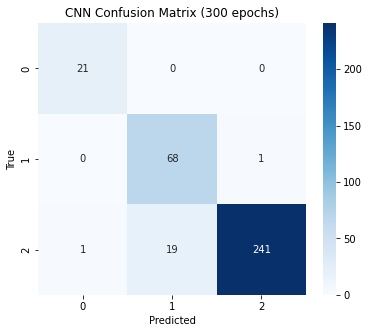


CNN Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7816    0.9855    0.8718        69
           2     0.9959    0.9234    0.9583       261

    accuracy                         0.9402       351
   macro avg     0.9107    0.9696    0.9356       351
weighted avg     0.9513    0.9402    0.9424       351



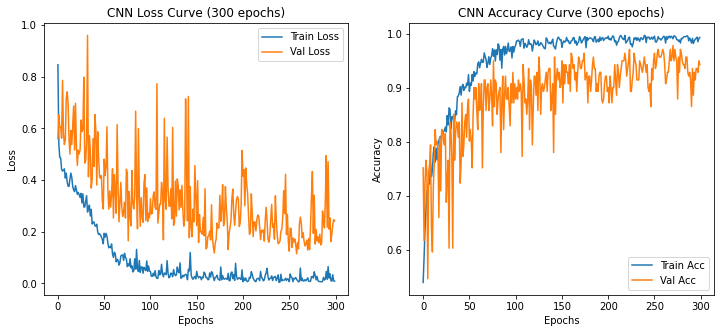

In [48]:
# Evaluate CNN model 50 epochs
evaluate_saved_model("cnn", 50)
# Evaluate CNN model 100 epochs
evaluate_saved_model("cnn", 100)
# Evaluate CNN model 150 epochs
evaluate_saved_model("cnn", 150)
# Evaluate CNN model 200 epochs
evaluate_saved_model("cnn", 200)
# Evaluate CNN model 250 epochs
evaluate_saved_model("cnn", 250)
# Evaluate CNN model 300 epochs
evaluate_saved_model("cnn", 300)

## 2. LSTM

In [49]:
# LSTM
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old LSTM files ====
for f in os.listdir():
    if f.startswith("lstm_") or f.startswith("lstm_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} "
          f"F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} "
          f"Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} "
          f"Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== LSTM Model ====
lstm = Sequential([
    LSTM(256, return_sequences=True, input_shape=(52,1)), Dropout(0.3),
    LSTM(128), Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
lstm.compile(optimizer=Adamax(learning_rate=0.01),
             loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = lstm.fit(x_train,y_train,validation_data=(x_val,y_val),
                     epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(lstm,x_test,y_test,f"LSTM after {target} epochs")
    lstm.save(f"lstm_model_{target}epochs.h5")
    pickle.dump(hist,open(f"lstm_history_{target}epochs.pkl","wb"))
    np.save(f"lstm_ypred_{target}epochs.npy",lstm.predict(x_test,verbose=0))
    np.save(f"lstm_ytrue_{target}epochs.npy",y_test)

print("\n✅ LSTM Training complete.")



LSTM after 50 epochs Performance:
Accuracy:0.7920 F1:0.7964 Recall:0.7920 Precision:0.8036

LSTM after 100 epochs Performance:
Accuracy:0.8519 F1:0.8494 Recall:0.8519 Precision:0.8476

LSTM after 150 epochs Performance:
Accuracy:0.8803 F1:0.8786 Recall:0.8803 Precision:0.8775

LSTM after 200 epochs Performance:
Accuracy:0.9060 F1:0.9057 Recall:0.9060 Precision:0.9057

LSTM after 250 epochs Performance:
Accuracy:0.8746 F1:0.8714 Recall:0.8746 Precision:0.8698

LSTM after 300 epochs Performance:
Accuracy:0.9430 F1:0.9435 Recall:0.9430 Precision:0.9448

✅ LSTM Training complete.


In [50]:
files = [f for f in os.listdir() if f.startswith("lstm_") or f.startswith("lstm_model_")]
files.sort()

print("Saved LSTM files:\n")
for f in files:
    print(f)

Saved LSTM files:

lstm_history_100epochs.pkl
lstm_history_150epochs.pkl
lstm_history_200epochs.pkl
lstm_history_250epochs.pkl
lstm_history_300epochs.pkl
lstm_history_50epochs.pkl
lstm_model_100epochs.h5
lstm_model_150epochs.h5
lstm_model_200epochs.h5
lstm_model_250epochs.h5
lstm_model_300epochs.h5
lstm_model_50epochs.h5
lstm_ypred_100epochs.npy
lstm_ypred_150epochs.npy
lstm_ypred_200epochs.npy
lstm_ypred_250epochs.npy
lstm_ypred_300epochs.npy
lstm_ypred_50epochs.npy
lstm_ytrue_100epochs.npy
lstm_ytrue_150epochs.npy
lstm_ytrue_200epochs.npy
lstm_ytrue_250epochs.npy
lstm_ytrue_300epochs.npy
lstm_ytrue_50epochs.npy


### 2.LSTM confusion matrix, classification report, loss & accuracy curve

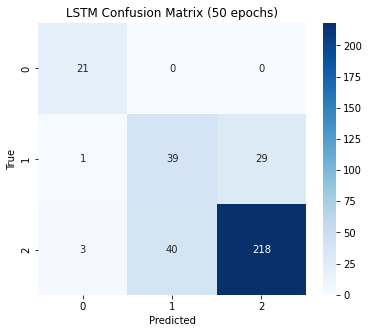


LSTM Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.8400    1.0000    0.9130        21
           1     0.4937    0.5652    0.5270        69
           2     0.8826    0.8352    0.8583       261

    accuracy                         0.7920       351
   macro avg     0.7388    0.8002    0.7661       351
weighted avg     0.8036    0.7920    0.7964       351



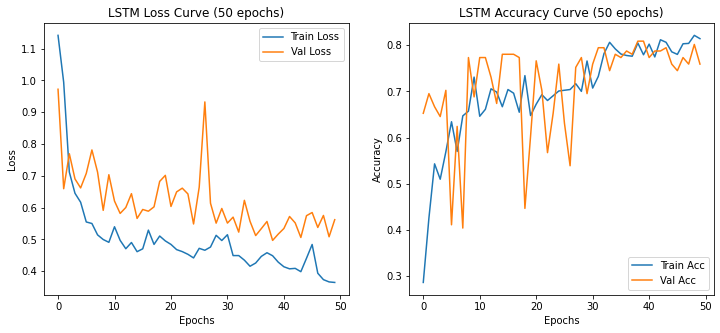

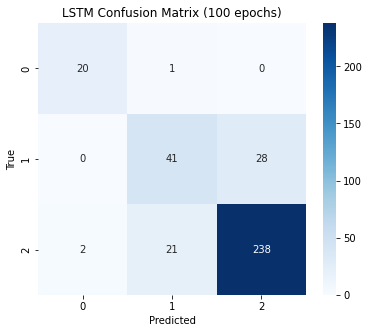


LSTM Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9091    0.9524    0.9302        21
           1     0.6508    0.5942    0.6212        69
           2     0.8947    0.9119    0.9032       261

    accuracy                         0.8519       351
   macro avg     0.8182    0.8195    0.8182       351
weighted avg     0.8476    0.8519    0.8494       351



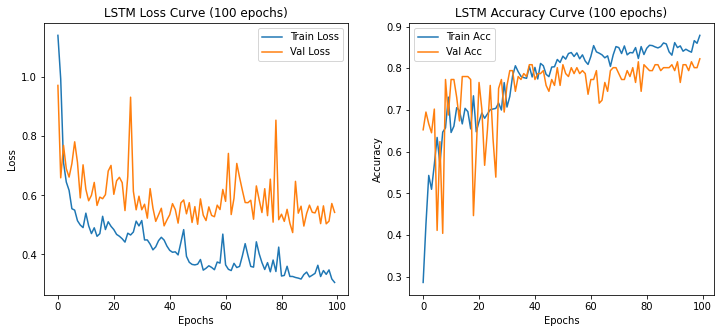

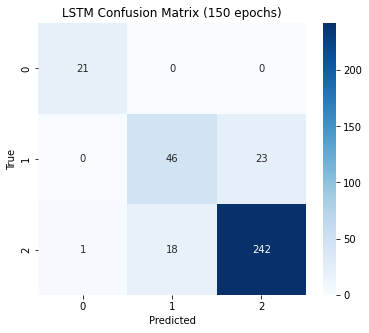


LSTM Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7188    0.6667    0.6917        69
           2     0.9132    0.9272    0.9202       261

    accuracy                         0.8803       351
   macro avg     0.8622    0.8646    0.8629       351
weighted avg     0.8775    0.8803    0.8786       351



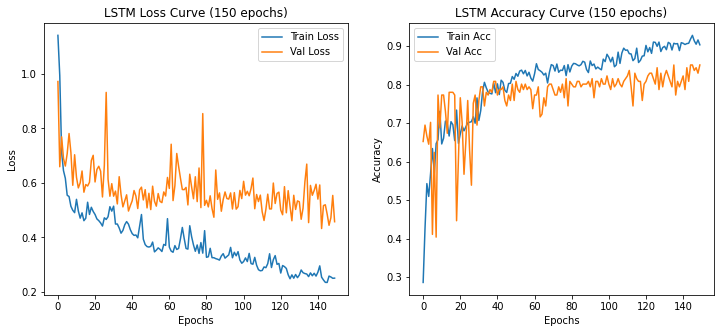

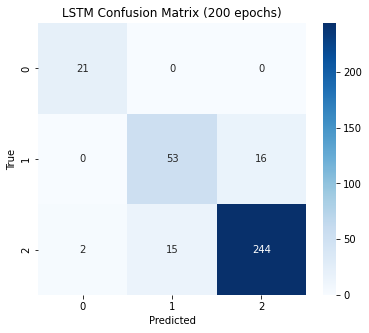


LSTM Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.7794    0.7681    0.7737        69
           2     0.9385    0.9349    0.9367       261

    accuracy                         0.9060       351
   macro avg     0.8770    0.9010    0.8883       351
weighted avg     0.9057    0.9060    0.9057       351



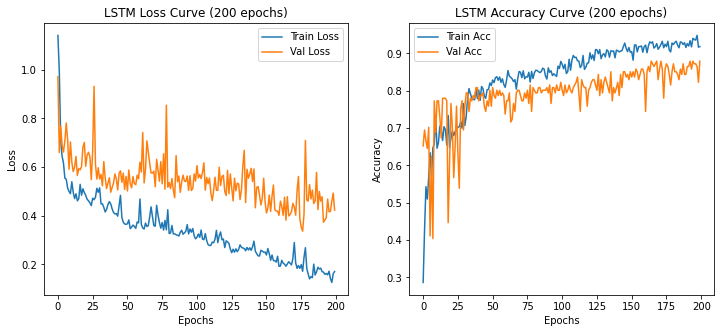

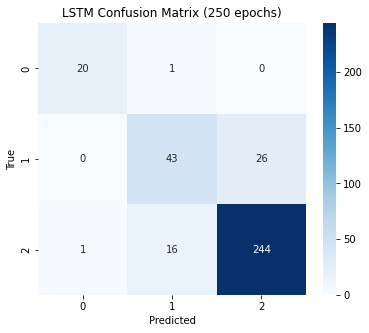


LSTM Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     0.9524    0.9524    0.9524        21
           1     0.7167    0.6232    0.6667        69
           2     0.9037    0.9349    0.9190       261

    accuracy                         0.8746       351
   macro avg     0.8576    0.8368    0.8460       351
weighted avg     0.8698    0.8746    0.8714       351



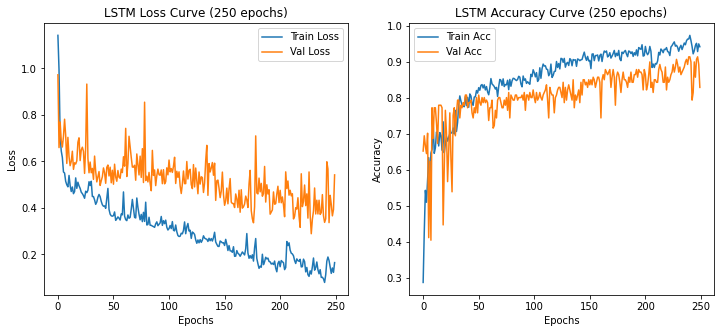

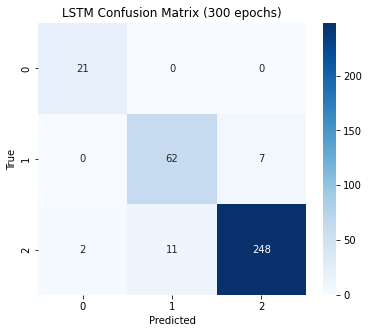


LSTM Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.8493    0.8986    0.8732        69
           2     0.9725    0.9502    0.9612       261

    accuracy                         0.9430       351
   macro avg     0.9116    0.9496    0.9297       351
weighted avg     0.9448    0.9430    0.9435       351



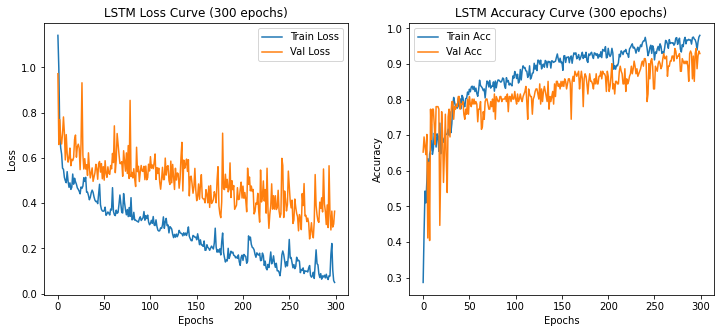

In [51]:
# Evaluate LSTM model 50 epochs
evaluate_saved_model("lstm", 50)
# Evaluate LSTM model 100 epochs
evaluate_saved_model("lstm", 100)
# Evaluate LSTM model 150 epochs
evaluate_saved_model("lstm", 150)
# Evaluate LSTM model 200 epochs
evaluate_saved_model("lstm", 200)
# Evaluate LSTM model 250 epochs
evaluate_saved_model("lstm", 250)
# Evaluate LSTM model 300 epochs
evaluate_saved_model("lstm", 300)

## 3. Bi LSTM

In [52]:
# Bi Lstm
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old BiLSTM files ====
for f in os.listdir():
    if f.startswith("bi_lstm_") or f.startswith("bi_lstm_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== BiLSTM Model ====
bi_lstm = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(52, 1)), Dropout(0.3),
    Bidirectional(LSTM(128)), Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
bi_lstm.compile(optimizer=Adamax(learning_rate=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = bi_lstm.fit(x_train,y_train,validation_data=(x_val,y_val),
                        epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(bi_lstm,x_test,y_test,f"BiLSTM after {target} epochs")
    bi_lstm.save(f"bi_lstm_model_{target}epochs.h5")
    pickle.dump(hist,open(f"bi_lstm_history_{target}epochs.pkl","wb"))
    np.save(f"bi_lstm_ypred_{target}epochs.npy",bi_lstm.predict(x_test,verbose=0))
    np.save(f"bi_lstm_ytrue_{target}epochs.npy",y_test)

print("\n✅ BiLSTM Training complete.")


BiLSTM after 50 epochs Performance:
Accuracy:0.8547 F1:0.8580 Recall:0.8547 Precision:0.8631

BiLSTM after 100 epochs Performance:
Accuracy:0.9202 F1:0.9211 Recall:0.9202 Precision:0.9227

BiLSTM after 150 epochs Performance:
Accuracy:0.9174 F1:0.9185 Recall:0.9174 Precision:0.9205

BiLSTM after 200 epochs Performance:
Accuracy:0.9316 F1:0.9321 Recall:0.9316 Precision:0.9329

BiLSTM after 250 epochs Performance:
Accuracy:0.9373 F1:0.9371 Recall:0.9373 Precision:0.9370

BiLSTM after 300 epochs Performance:
Accuracy:0.9402 F1:0.9401 Recall:0.9402 Precision:0.9402

✅ BiLSTM Training complete.


In [53]:
files = [f for f in os.listdir() if f.startswith("bi_lstm_") or f.startswith("bi_lstm_model_")]
files.sort()

print("Saved BI-LSTM files:\n")
for f in files:
    print(f)

Saved BI-LSTM files:

bi_lstm_history_100epochs.pkl
bi_lstm_history_150epochs.pkl
bi_lstm_history_200epochs.pkl
bi_lstm_history_250epochs.pkl
bi_lstm_history_300epochs.pkl
bi_lstm_history_50epochs.pkl
bi_lstm_model_100epochs.h5
bi_lstm_model_150epochs.h5
bi_lstm_model_200epochs.h5
bi_lstm_model_250epochs.h5
bi_lstm_model_300epochs.h5
bi_lstm_model_50epochs.h5
bi_lstm_ypred_100epochs.npy
bi_lstm_ypred_150epochs.npy
bi_lstm_ypred_200epochs.npy
bi_lstm_ypred_250epochs.npy
bi_lstm_ypred_300epochs.npy
bi_lstm_ypred_50epochs.npy
bi_lstm_ytrue_100epochs.npy
bi_lstm_ytrue_150epochs.npy
bi_lstm_ytrue_200epochs.npy
bi_lstm_ytrue_250epochs.npy
bi_lstm_ytrue_300epochs.npy
bi_lstm_ytrue_50epochs.npy


### 3.BiLSTM confusion matrix, classification report, loss & accuracy curve

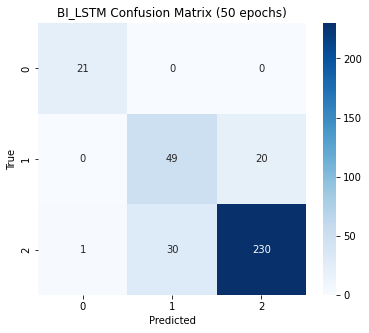


BI_LSTM Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.6203    0.7101    0.6622        69
           2     0.9200    0.8812    0.9002       261

    accuracy                         0.8547       351
   macro avg     0.8316    0.8638    0.8464       351
weighted avg     0.8631    0.8547    0.8580       351



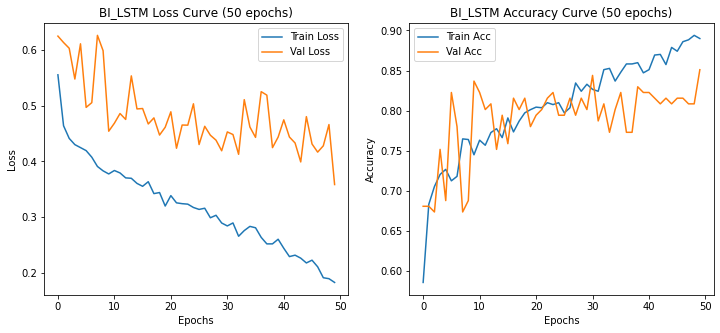

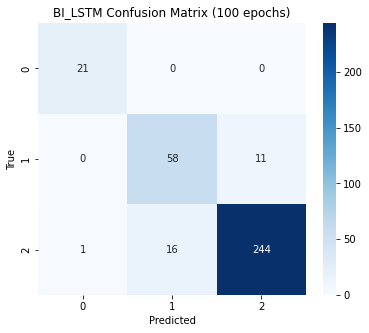


BI_LSTM Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7838    0.8406    0.8112        69
           2     0.9569    0.9349    0.9457       261

    accuracy                         0.9202       351
   macro avg     0.8984    0.9251    0.9112       351
weighted avg     0.9227    0.9202    0.9211       351



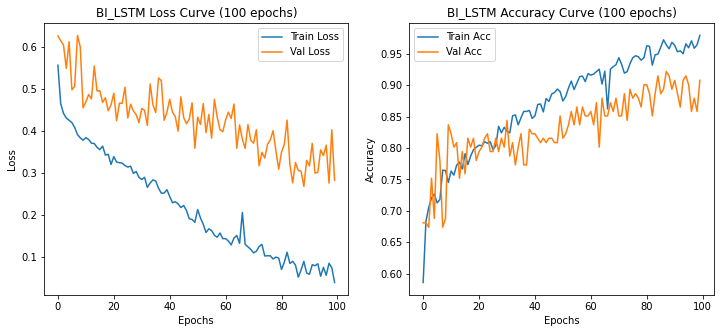

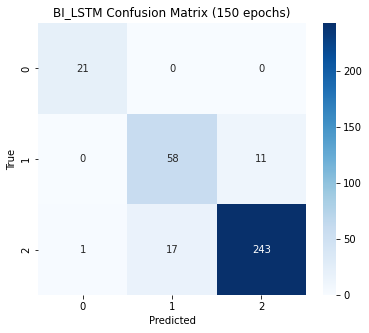


BI_LSTM Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7733    0.8406    0.8056        69
           2     0.9567    0.9310    0.9437       261

    accuracy                         0.9174       351
   macro avg     0.8949    0.9239    0.9087       351
weighted avg     0.9205    0.9174    0.9185       351



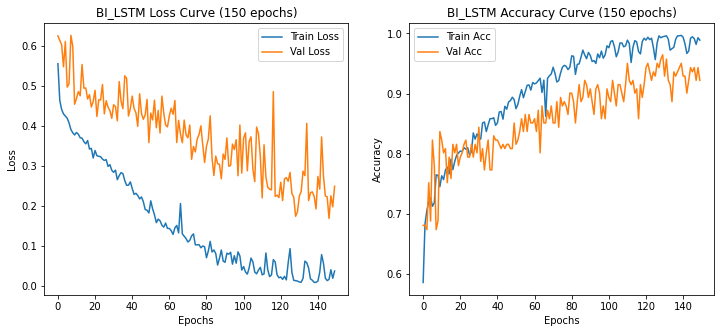

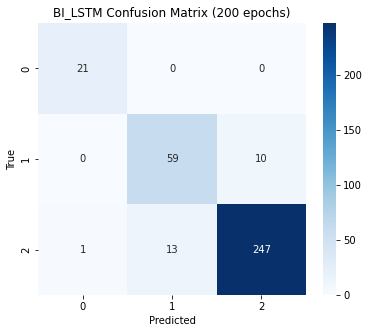


BI_LSTM Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8194    0.8551    0.8369        69
           2     0.9611    0.9464    0.9537       261

    accuracy                         0.9316       351
   macro avg     0.9117    0.9338    0.9224       351
weighted avg     0.9329    0.9316    0.9321       351



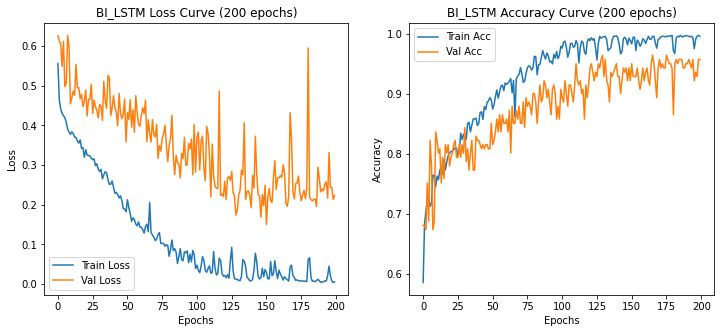

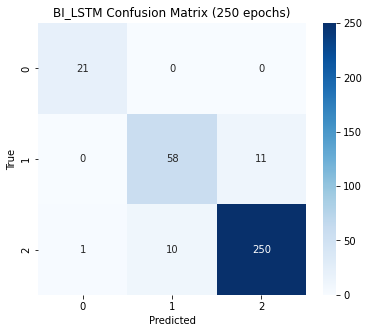


BI_LSTM Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8529    0.8406    0.8467        69
           2     0.9579    0.9579    0.9579       261

    accuracy                         0.9373       351
   macro avg     0.9218    0.9328    0.9271       351
weighted avg     0.9370    0.9373    0.9371       351



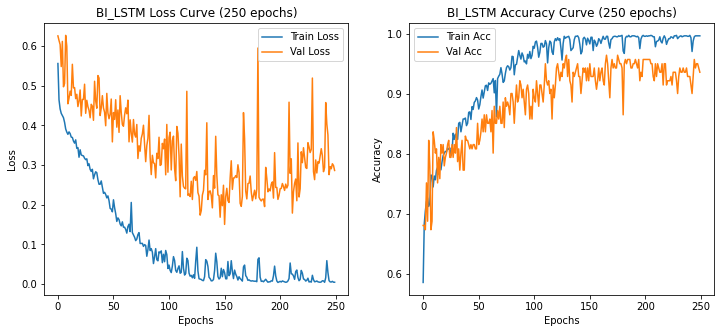

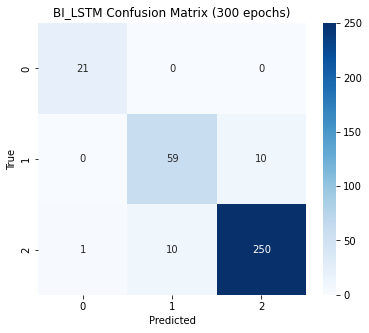


BI_LSTM Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8551    0.8551    0.8551        69
           2     0.9615    0.9579    0.9597       261

    accuracy                         0.9402       351
   macro avg     0.9237    0.9376    0.9305       351
weighted avg     0.9402    0.9402    0.9401       351



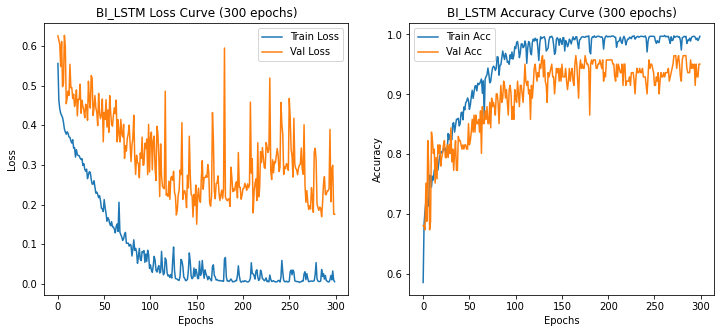

In [54]:
# Evaluate BiLSTM model 50 epochs
evaluate_saved_model("bi_lstm", 50)
# Evaluate BiLSTM model 100 epochs
evaluate_saved_model("bi_lstm", 100)
# Evaluate BiLSTM model 150 epochs
evaluate_saved_model("bi_lstm", 150)
# Evaluate BiLSTM model 200 epochs
evaluate_saved_model("bi_lstm", 200)
# Evaluate BiLSTM model 250 epochs
evaluate_saved_model("bi_lstm", 250)
# Evaluate BiLSTM model 300 epochs
evaluate_saved_model("bi_lstm", 300)

## 4. GRU

In [55]:
#GRU
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old GRU files ====
for f in os.listdir():
    if f.startswith("gru_") or f.startswith("gru_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== GRU Model ====
gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(52, 1)), Dropout(0.3),
    GRU(128), Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
gru.compile(optimizer=Adamax(learning_rate=0.01),
            loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = gru.fit(x_train,y_train,validation_data=(x_val,y_val),
                    epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(gru,x_test,y_test,f"GRU after {target} epochs")
    gru.save(f"gru_model_{target}epochs.h5")
    pickle.dump(hist,open(f"gru_history_{target}epochs.pkl","wb"))
    np.save(f"gru_ypred_{target}epochs.npy",gru.predict(x_test,verbose=0))
    np.save(f"gru_ytrue_{target}epochs.npy",y_test)

print("\n✅ GRU Training complete.")



GRU after 50 epochs Performance:
Accuracy:0.9088 F1:0.9100 Recall:0.9088 Precision:0.9123

GRU after 100 epochs Performance:
Accuracy:0.9259 F1:0.9261 Recall:0.9259 Precision:0.9263

GRU after 150 epochs Performance:
Accuracy:0.9145 F1:0.9153 Recall:0.9145 Precision:0.9167

GRU after 200 epochs Performance:
Accuracy:0.9316 F1:0.9328 Recall:0.9316 Precision:0.9358

GRU after 250 epochs Performance:
Accuracy:0.9487 F1:0.9486 Recall:0.9487 Precision:0.9485

GRU after 300 epochs Performance:
Accuracy:0.9316 F1:0.9316 Recall:0.9316 Precision:0.9320

✅ GRU Training complete.


In [56]:
files = [f for f in os.listdir() if f.startswith("gru_") or f.startswith("gru_model_")]
files.sort()

print("Saved GRU files:\n")
for f in files:
    print(f)

Saved GRU files:

gru_history_100epochs.pkl
gru_history_150epochs.pkl
gru_history_200epochs.pkl
gru_history_250epochs.pkl
gru_history_300epochs.pkl
gru_history_50epochs.pkl
gru_model_100epochs.h5
gru_model_150epochs.h5
gru_model_200epochs.h5
gru_model_250epochs.h5
gru_model_300epochs.h5
gru_model_50epochs.h5
gru_ypred_100epochs.npy
gru_ypred_150epochs.npy
gru_ypred_200epochs.npy
gru_ypred_250epochs.npy
gru_ypred_300epochs.npy
gru_ypred_50epochs.npy
gru_ytrue_100epochs.npy
gru_ytrue_150epochs.npy
gru_ytrue_200epochs.npy
gru_ytrue_250epochs.npy
gru_ytrue_300epochs.npy
gru_ytrue_50epochs.npy


### 4.GRU confusion matrix, classification report, loss & accuracy curve

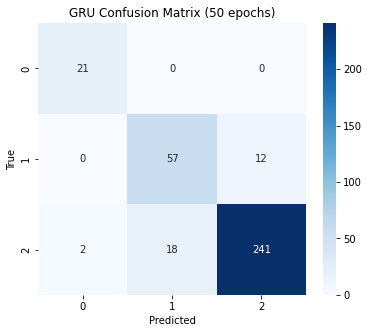


GRU Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.7600    0.8261    0.7917        69
           2     0.9526    0.9234    0.9377       261

    accuracy                         0.9088       351
   macro avg     0.8752    0.9165    0.8947       351
weighted avg     0.9123    0.9088    0.9100       351



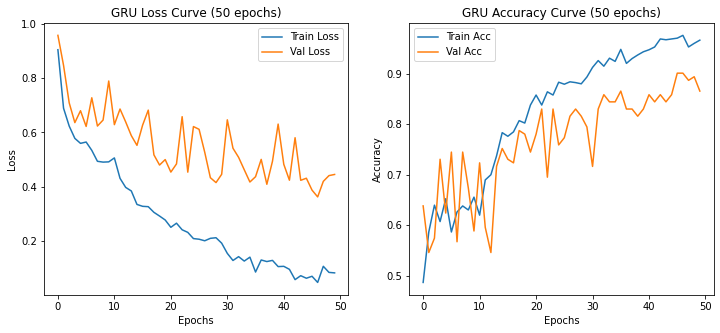

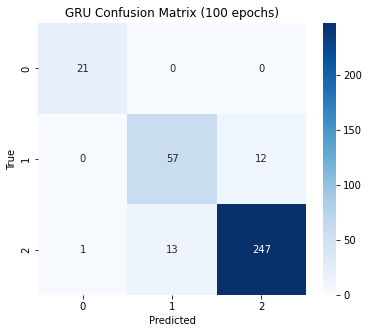


GRU Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8143    0.8261    0.8201        69
           2     0.9537    0.9464    0.9500       261

    accuracy                         0.9259       351
   macro avg     0.9075    0.9241    0.9156       351
weighted avg     0.9263    0.9259    0.9261       351



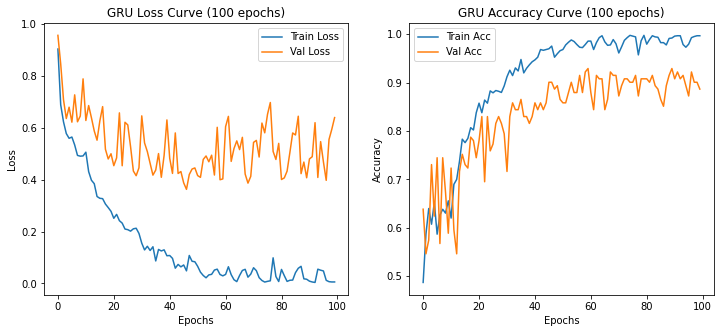

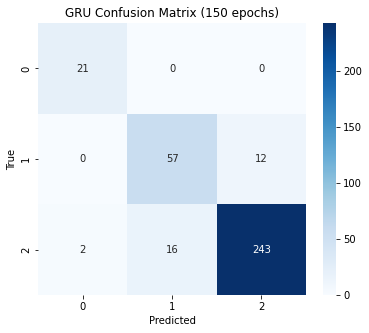


GRU Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.7808    0.8261    0.8028        69
           2     0.9529    0.9310    0.9419       261

    accuracy                         0.9145       351
   macro avg     0.8823    0.9190    0.8997       351
weighted avg     0.9167    0.9145    0.9153       351



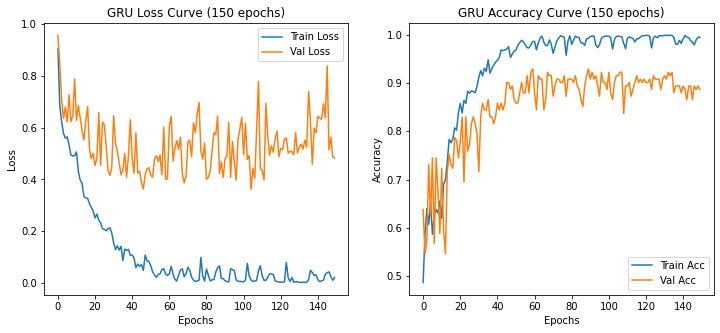

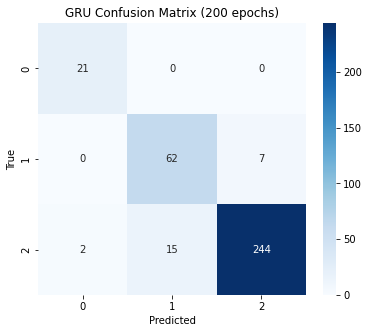


GRU Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        21
           1     0.8052    0.8986    0.8493        69
           2     0.9721    0.9349    0.9531       261

    accuracy                         0.9316       351
   macro avg     0.8968    0.9445    0.9190       351
weighted avg     0.9358    0.9316    0.9328       351



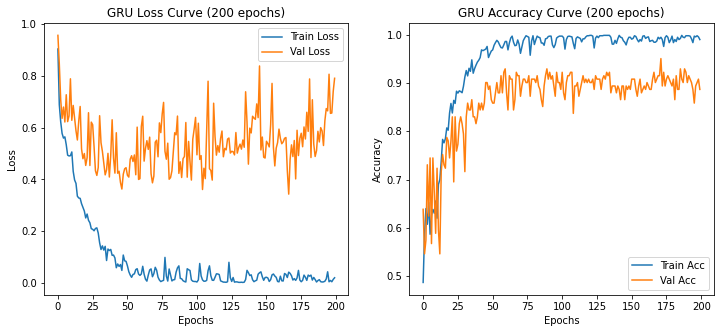

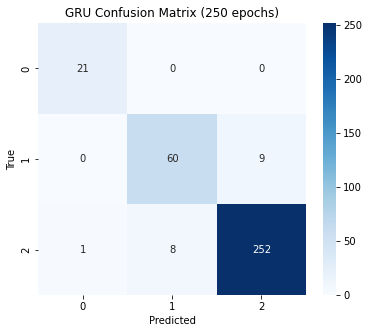


GRU Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8824    0.8696    0.8759        69
           2     0.9655    0.9655    0.9655       261

    accuracy                         0.9487       351
   macro avg     0.9341    0.9450    0.9394       351
weighted avg     0.9485    0.9487    0.9486       351



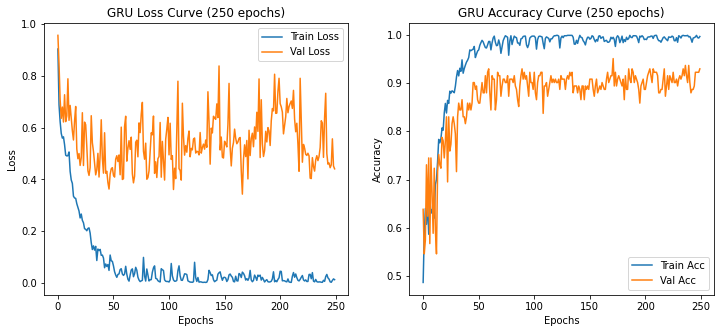

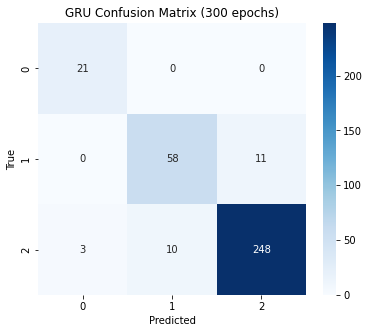


GRU Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333        21
           1     0.8529    0.8406    0.8467        69
           2     0.9575    0.9502    0.9538       261

    accuracy                         0.9316       351
   macro avg     0.8952    0.9303    0.9113       351
weighted avg     0.9320    0.9316    0.9316       351



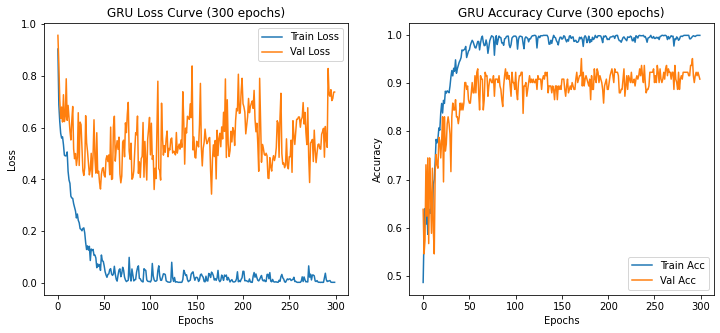

In [57]:
# Evaluate GRU model 50 epochs
evaluate_saved_model("gru", 50)
# Evaluate GRU model 100 epochs
evaluate_saved_model("gru", 100)
# Evaluate GRU model 150 epochs
evaluate_saved_model("gru", 150)
# Evaluate GRU model 200 epochs
evaluate_saved_model("gru", 200)
# Evaluate GRU model 250 epochs
evaluate_saved_model("gru", 250)
# Evaluate GRU model 300 epochs
evaluate_saved_model("gru", 300)

## Hybrid Model

## 1. CNN + LSTM

In [58]:
#CNN+LSTM
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old CNN+LSTM files ====
for f in os.listdir():
    if f.startswith("cnn_lstm_") or f.startswith("cnn_lstm_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== CNN+LSTM Hybrid Model ====
cnn_lstm = Sequential([
    # CNN layers
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(52, 1)),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),

    # LSTM layers
    LSTM(128, return_sequences=True),
    LSTM(64),

    # Dense layers
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_lstm.compile(optimizer=Adamax(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = cnn_lstm.fit(x_train,y_train,validation_data=(x_val,y_val),
                         epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(cnn_lstm,x_test,y_test,f"CNN+LSTM after {target} epochs")
    cnn_lstm.save(f"cnn_lstm_model_{target}epochs.h5")
    pickle.dump(hist,open(f"cnn_lstm_history_{target}epochs.pkl","wb"))
    np.save(f"cnn_lstm_ypred_{target}epochs.npy",cnn_lstm.predict(x_test,verbose=0))
    np.save(f"cnn_lstm_ytrue_{target}epochs.npy",y_test)

print("\n✅ CNN+LSTM Hybrid Training complete.")



CNN+LSTM after 50 epochs Performance:
Accuracy:0.8689 F1:0.8716 Recall:0.8689 Precision:0.8759

CNN+LSTM after 100 epochs Performance:
Accuracy:0.8746 F1:0.8811 Recall:0.8746 Precision:0.9001

CNN+LSTM after 150 epochs Performance:
Accuracy:0.9088 F1:0.9131 Recall:0.9088 Precision:0.9261

CNN+LSTM after 200 epochs Performance:
Accuracy:0.8376 F1:0.8512 Recall:0.8376 Precision:0.9076

CNN+LSTM after 250 epochs Performance:
Accuracy:0.9373 F1:0.9403 Recall:0.9373 Precision:0.9525

CNN+LSTM after 300 epochs Performance:
Accuracy:0.9487 F1:0.9506 Recall:0.9487 Precision:0.9576

✅ CNN+LSTM Hybrid Training complete.


In [59]:
files = [f for f in os.listdir() if f.startswith("cnn_lstm_") or f.startswith("cnn_lstm_model_")]
files.sort()

print("Saved GRU files:\n")
for f in files:
    print(f)

Saved GRU files:

cnn_lstm_history_100epochs.pkl
cnn_lstm_history_150epochs.pkl
cnn_lstm_history_200epochs.pkl
cnn_lstm_history_250epochs.pkl
cnn_lstm_history_300epochs.pkl
cnn_lstm_history_50epochs.pkl
cnn_lstm_model_100epochs.h5
cnn_lstm_model_150epochs.h5
cnn_lstm_model_200epochs.h5
cnn_lstm_model_250epochs.h5
cnn_lstm_model_300epochs.h5
cnn_lstm_model_50epochs.h5
cnn_lstm_ypred_100epochs.npy
cnn_lstm_ypred_150epochs.npy
cnn_lstm_ypred_200epochs.npy
cnn_lstm_ypred_250epochs.npy
cnn_lstm_ypred_300epochs.npy
cnn_lstm_ypred_50epochs.npy
cnn_lstm_ytrue_100epochs.npy
cnn_lstm_ytrue_150epochs.npy
cnn_lstm_ytrue_200epochs.npy
cnn_lstm_ytrue_250epochs.npy
cnn_lstm_ytrue_300epochs.npy
cnn_lstm_ytrue_50epochs.npy


### 1.CNN+LSTM confusion matrix, classification report, loss & accuracy curve

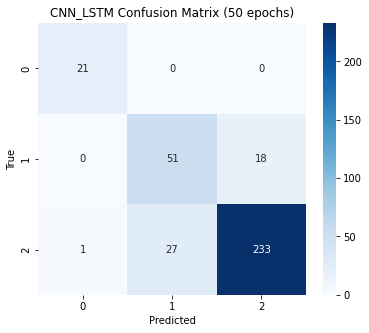


CNN_LSTM Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.6538    0.7391    0.6939        69
           2     0.9283    0.8927    0.9102       261

    accuracy                         0.8689       351
   macro avg     0.8456    0.8773    0.8603       351
weighted avg     0.8759    0.8689    0.8716       351



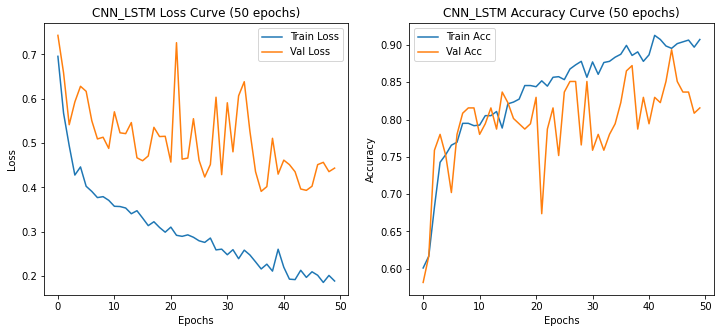

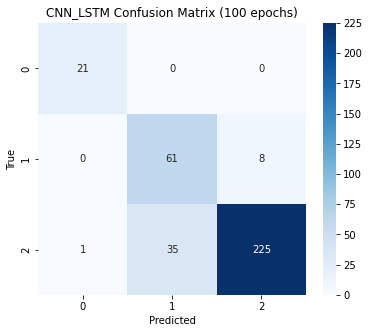


CNN_LSTM Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.6354    0.8841    0.7394        69
           2     0.9657    0.8621    0.9109       261

    accuracy                         0.8746       351
   macro avg     0.8519    0.9154    0.8757       351
weighted avg     0.9001    0.8746    0.8811       351



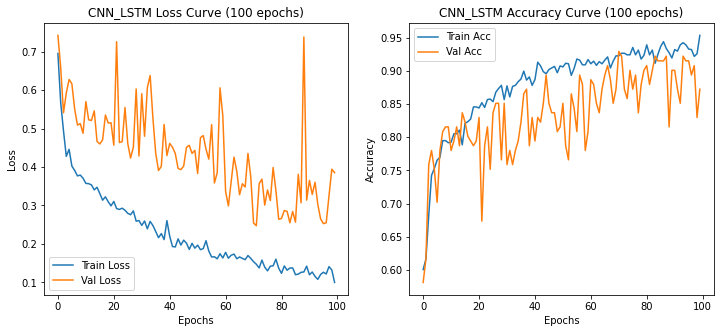

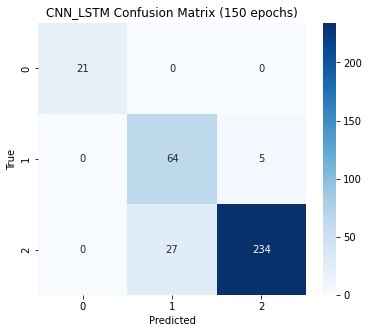


CNN_LSTM Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.7033    0.9275    0.8000        69
           2     0.9791    0.8966    0.9360       261

    accuracy                         0.9088       351
   macro avg     0.8941    0.9414    0.9120       351
weighted avg     0.9261    0.9088    0.9131       351



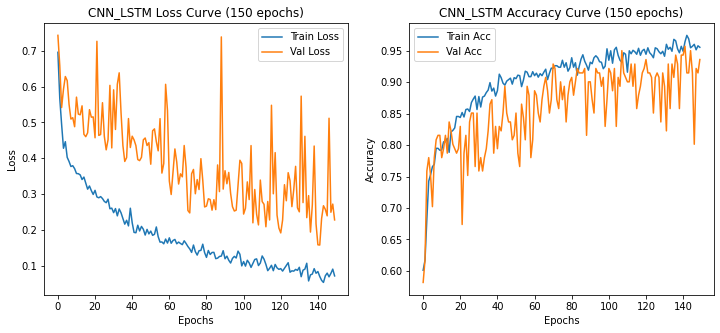

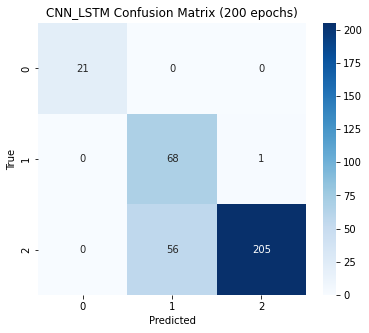


CNN_LSTM Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.5484    0.9855    0.7047        69
           2     0.9951    0.7854    0.8779       261

    accuracy                         0.8376       351
   macro avg     0.8478    0.9236    0.8609       351
weighted avg     0.9076    0.8376    0.8512       351



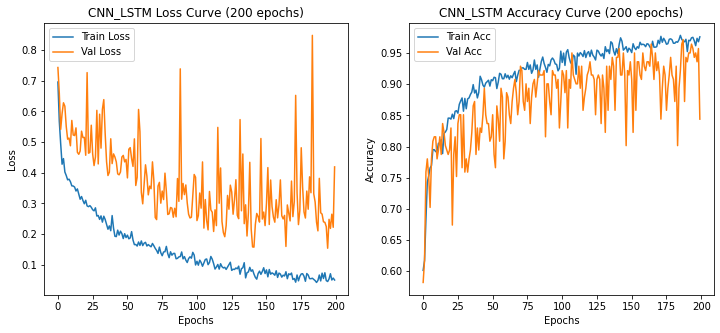

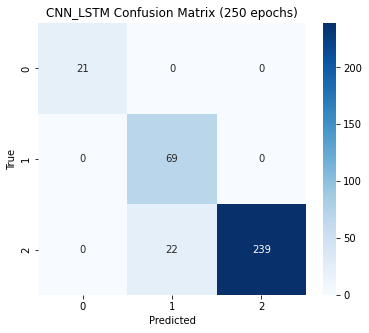


CNN_LSTM Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.7582    1.0000    0.8625        69
           2     1.0000    0.9157    0.9560       261

    accuracy                         0.9373       351
   macro avg     0.9194    0.9719    0.9395       351
weighted avg     0.9525    0.9373    0.9403       351



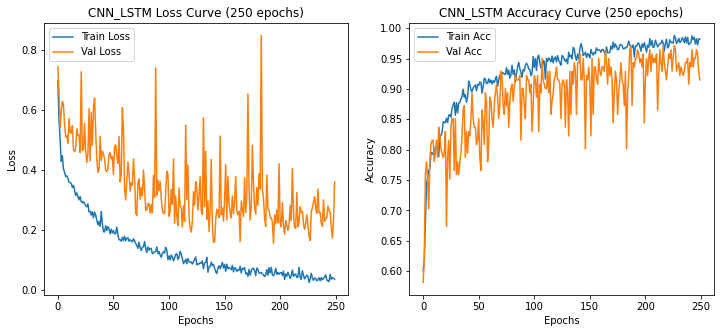

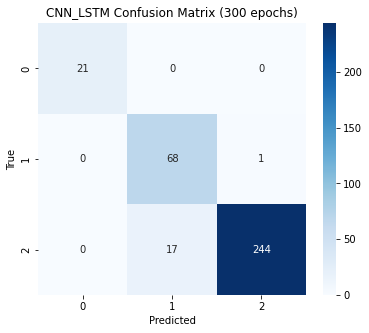


CNN_LSTM Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8000    0.9855    0.8831        69
           2     0.9959    0.9349    0.9644       261

    accuracy                         0.9487       351
   macro avg     0.9320    0.9735    0.9492       351
weighted avg     0.9576    0.9487    0.9506       351



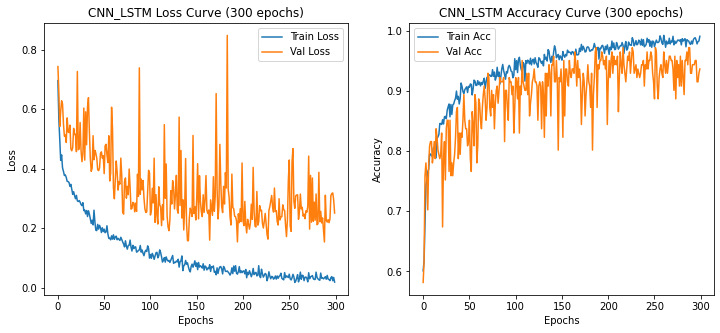

In [60]:
# Evaluate CNN+LSTM model 50 epochs
evaluate_saved_model("cnn_lstm", 50)
# Evaluate CNN+LSTM model 100 epochs
evaluate_saved_model("cnn_lstm", 100)
# Evaluate CNN+LSTM model 150 epochs
evaluate_saved_model("cnn_lstm", 150)
# Evaluate CNN+LSTM model 200 epochs
evaluate_saved_model("cnn_lstm", 200)
# Evaluate CNN+LSTM model 250 epochs
evaluate_saved_model("cnn_lstm", 250)
# Evaluate CNN+LSTM model 300 epochs
evaluate_saved_model("cnn_lstm", 300)

## 2. CNN + Bi LSTM

In [61]:
#CNN + Bi LSTM
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old CNN+BiLSTM files ====
for f in os.listdir():
    if f.startswith("cnn_bilstm_") or f.startswith("cnn_bilstm_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== CNN+BiLSTM Hybrid Model ====
cnn_bilstm = Sequential([
    # CNN layers
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(52, 1)),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),

    # BiLSTM layers
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),

    # Dense layers
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_bilstm.compile(optimizer=Adamax(learning_rate=0.001),
                   loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = cnn_bilstm.fit(x_train,y_train,validation_data=(x_val,y_val),
                            epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(cnn_bilstm,x_test,y_test,f"CNN+BiLSTM after {target} epochs")
    cnn_bilstm.save(f"cnn_bilstm_model_{target}epochs.h5")
    pickle.dump(hist,open(f"cnn_bilstm_history_{target}epochs.pkl","wb"))
    np.save(f"cnn_bilstm_ypred_{target}epochs.npy",cnn_bilstm.predict(x_test,verbose=0))
    np.save(f"cnn_bilstm_ytrue_{target}epochs.npy",y_test)

print("\n✅ CNN+BiLSTM Hybrid Training complete.")



CNN+BiLSTM after 50 epochs Performance:
Accuracy:0.9117 F1:0.9150 Recall:0.9117 Precision:0.9246

CNN+BiLSTM after 100 epochs Performance:
Accuracy:0.8917 F1:0.8968 Recall:0.8917 Precision:0.9103

CNN+BiLSTM after 150 epochs Performance:
Accuracy:0.9544 F1:0.9555 Recall:0.9544 Precision:0.9588

CNN+BiLSTM after 200 epochs Performance:
Accuracy:0.9544 F1:0.9555 Recall:0.9544 Precision:0.9588

CNN+BiLSTM after 250 epochs Performance:
Accuracy:0.9601 F1:0.9611 Recall:0.9601 Precision:0.9642

CNN+BiLSTM after 300 epochs Performance:
Accuracy:0.9601 F1:0.9609 Recall:0.9601 Precision:0.9631

✅ CNN+BiLSTM Hybrid Training complete.


In [62]:
files = [f for f in os.listdir() if f.startswith("cnn_bilstm_") or f.startswith("cnn_bilstm_model_")]
files.sort()

print("Saved CNN+BiLSTM files:\n")
for f in files:
    print(f)

Saved CNN+BiLSTM files:

cnn_bilstm_history_100epochs.pkl
cnn_bilstm_history_150epochs.pkl
cnn_bilstm_history_200epochs.pkl
cnn_bilstm_history_250epochs.pkl
cnn_bilstm_history_300epochs.pkl
cnn_bilstm_history_50epochs.pkl
cnn_bilstm_model_100epochs.h5
cnn_bilstm_model_150epochs.h5
cnn_bilstm_model_200epochs.h5
cnn_bilstm_model_250epochs.h5
cnn_bilstm_model_300epochs.h5
cnn_bilstm_model_50epochs.h5
cnn_bilstm_ypred_100epochs.npy
cnn_bilstm_ypred_150epochs.npy
cnn_bilstm_ypred_200epochs.npy
cnn_bilstm_ypred_250epochs.npy
cnn_bilstm_ypred_300epochs.npy
cnn_bilstm_ypred_50epochs.npy
cnn_bilstm_ytrue_100epochs.npy
cnn_bilstm_ytrue_150epochs.npy
cnn_bilstm_ytrue_200epochs.npy
cnn_bilstm_ytrue_250epochs.npy
cnn_bilstm_ytrue_300epochs.npy
cnn_bilstm_ytrue_50epochs.npy


### 2.CNN+BiLSTM confusion matrix, classification report, loss & accuracy curve

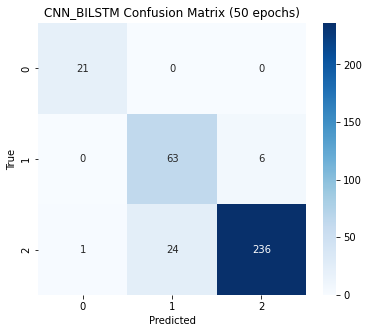


CNN_BILSTM Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.7241    0.9130    0.8077        69
           2     0.9752    0.9042    0.9384       261

    accuracy                         0.9117       351
   macro avg     0.8846    0.9391    0.9076       351
weighted avg     0.9246    0.9117    0.9150       351



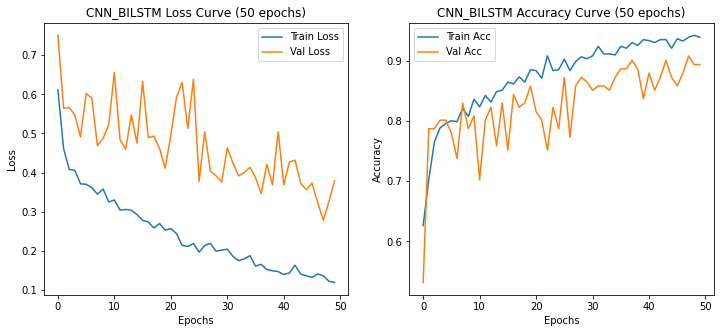

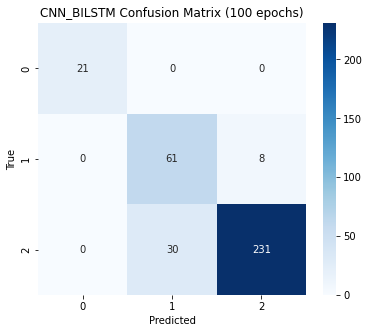


CNN_BILSTM Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.6703    0.8841    0.7625        69
           2     0.9665    0.8851    0.9240       261

    accuracy                         0.8917       351
   macro avg     0.8790    0.9230    0.8955       351
weighted avg     0.9103    0.8917    0.8968       351



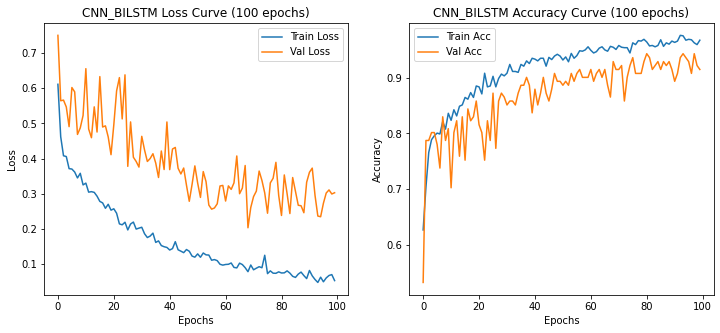

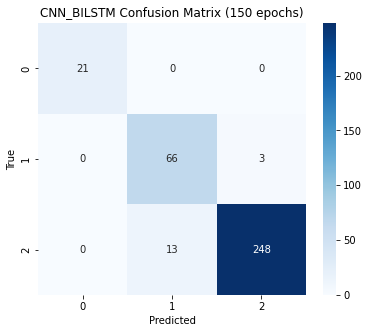


CNN_BILSTM Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8354    0.9565    0.8919        69
           2     0.9880    0.9502    0.9688       261

    accuracy                         0.9544       351
   macro avg     0.9412    0.9689    0.9535       351
weighted avg     0.9588    0.9544    0.9555       351



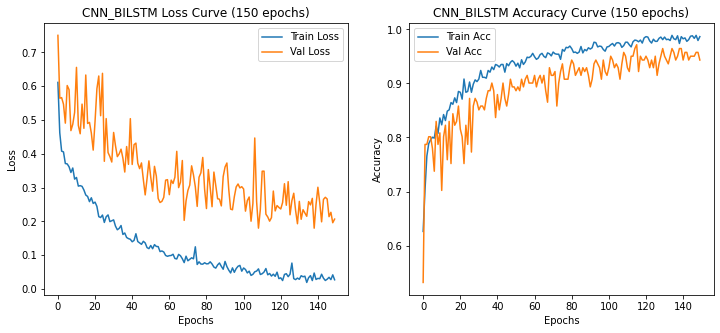

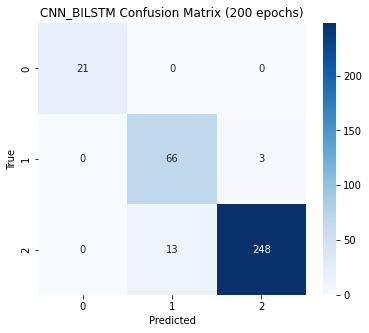


CNN_BILSTM Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8354    0.9565    0.8919        69
           2     0.9880    0.9502    0.9688       261

    accuracy                         0.9544       351
   macro avg     0.9412    0.9689    0.9535       351
weighted avg     0.9588    0.9544    0.9555       351



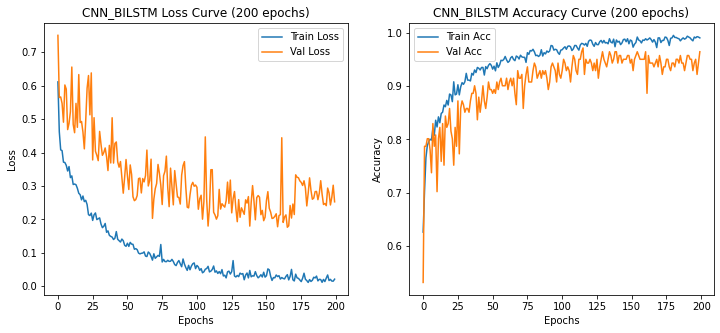

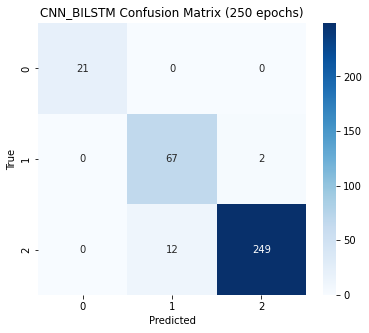


CNN_BILSTM Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8481    0.9710    0.9054        69
           2     0.9920    0.9540    0.9727       261

    accuracy                         0.9601       351
   macro avg     0.9467    0.9750    0.9594       351
weighted avg     0.9642    0.9601    0.9611       351



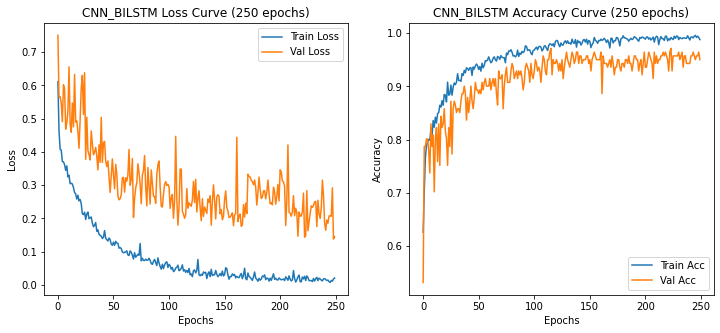

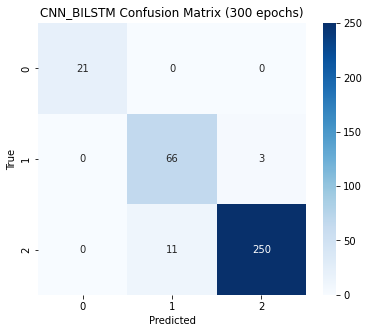


CNN_BILSTM Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8571    0.9565    0.9041        69
           2     0.9881    0.9579    0.9728       261

    accuracy                         0.9601       351
   macro avg     0.9484    0.9715    0.9590       351
weighted avg     0.9631    0.9601    0.9609       351



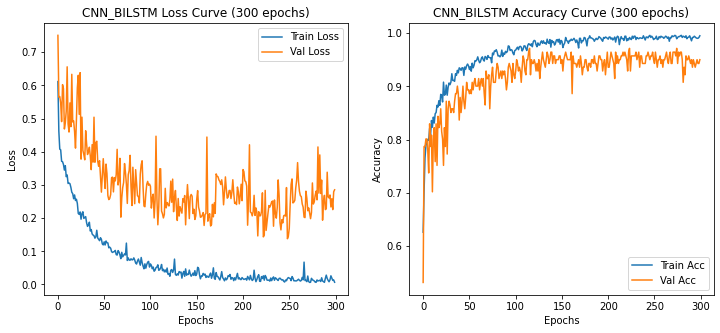

In [63]:
# Evaluate CNN+BiLSTM model 50 epochs
evaluate_saved_model("cnn_bilstm", 50)
# Evaluate CNN+BiLSTM model 100 epochs
evaluate_saved_model("cnn_bilstm", 100)
# Evaluate CNN+BiLSTM model 150 epochs
evaluate_saved_model("cnn_bilstm", 150)
# Evaluate CNN+BiLSTM model 200 epochs
evaluate_saved_model("cnn_bilstm", 200)
# Evaluate CNN+BiLSTM model 250 epochs
evaluate_saved_model("cnn_bilstm", 250)
# Evaluate CNN+BiLSTM model 300 epochs
evaluate_saved_model("cnn_bilstm", 300)

In [64]:
#CNN+GRU
import os, pickle, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ==== Remove old CNN+GRU files ====
for f in os.listdir():
    if f.startswith("cnn_gru_") or f.startswith("cnn_gru_model_"):
        os.remove(f)

# ==== Evaluation function ====
def eval_model(model, x_test, y_test, name):
    y_pred = model.predict(x_test, verbose=0)
    y_true = np.argmax(y_test,1)
    y_pred_classes = np.argmax(y_pred,1)
    print(f"\n{name} Performance:")
    print(f"Accuracy:{accuracy_score(y_true,y_pred_classes):.4f} F1:{f1_score(y_true,y_pred_classes,average='weighted'):.4f} Recall:{recall_score(y_true,y_pred_classes,average='weighted'):.4f} Precision:{precision_score(y_true,y_pred_classes,average='weighted'):.4f}")

# ==== CNN+GRU Hybrid Model ====
cnn_gru = Sequential([
    # CNN layers
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(52, 1)),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),

    # GRU layers
    GRU(128, return_sequences=True),
    GRU(64),

    # Dense layers
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_gru.compile(optimizer=Adamax(learning_rate=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])

# ==== Training ====
epochs_list=[50,100,150,200,250,300]; curr=0; hist={}

for target in epochs_list:
    while curr<target:
        h = cnn_gru.fit(x_train,y_train,validation_data=(x_val,y_val),
                        epochs=1,batch_size=8,class_weight=class_weight,verbose=0)
        for k,v in h.history.items(): hist.setdefault(k,[]).extend(v)
        curr+=1

    eval_model(cnn_gru,x_test,y_test,f"CNN+GRU after {target} epochs")
    cnn_gru.save(f"cnn_gru_model_{target}epochs.h5")
    pickle.dump(hist,open(f"cnn_gru_history_{target}epochs.pkl","wb"))
    np.save(f"cnn_gru_ypred_{target}epochs.npy",cnn_gru.predict(x_test,verbose=0))
    np.save(f"cnn_gru_ytrue_{target}epochs.npy",y_test)

print("\n✅ CNN+GRU Hybrid Training complete.")



CNN+GRU after 50 epochs Performance:
Accuracy:0.9373 F1:0.9371 Recall:0.9373 Precision:0.9370

CNN+GRU after 100 epochs Performance:
Accuracy:0.9516 F1:0.9520 Recall:0.9516 Precision:0.9529

CNN+GRU after 150 epochs Performance:
Accuracy:0.9544 F1:0.9557 Recall:0.9544 Precision:0.9601

CNN+GRU after 200 epochs Performance:
Accuracy:0.9601 F1:0.9611 Recall:0.9601 Precision:0.9642

CNN+GRU after 250 epochs Performance:
Accuracy:0.9373 F1:0.9403 Recall:0.9373 Precision:0.9525

CNN+GRU after 300 epochs Performance:
Accuracy:0.9715 F1:0.9721 Recall:0.9715 Precision:0.9741

✅ CNN+GRU Hybrid Training complete.


In [65]:
files = [f for f in os.listdir() if f.startswith("cnn_gru_") or f.startswith("cnn_gru_model_")]
files.sort()

print("Saved CNN+GRU files:\n")
for f in files:
    print(f)

Saved CNN+GRU files:

cnn_gru_history_100epochs.pkl
cnn_gru_history_150epochs.pkl
cnn_gru_history_200epochs.pkl
cnn_gru_history_250epochs.pkl
cnn_gru_history_300epochs.pkl
cnn_gru_history_50epochs.pkl
cnn_gru_model_100epochs.h5
cnn_gru_model_150epochs.h5
cnn_gru_model_200epochs.h5
cnn_gru_model_250epochs.h5
cnn_gru_model_300epochs.h5
cnn_gru_model_50epochs.h5
cnn_gru_ypred_100epochs.npy
cnn_gru_ypred_150epochs.npy
cnn_gru_ypred_200epochs.npy
cnn_gru_ypred_250epochs.npy
cnn_gru_ypred_300epochs.npy
cnn_gru_ypred_50epochs.npy
cnn_gru_ytrue_100epochs.npy
cnn_gru_ytrue_150epochs.npy
cnn_gru_ytrue_200epochs.npy
cnn_gru_ytrue_250epochs.npy
cnn_gru_ytrue_300epochs.npy
cnn_gru_ytrue_50epochs.npy


### 3.CNN+GRU confusion matrix, classification report, loss & accuracy curve

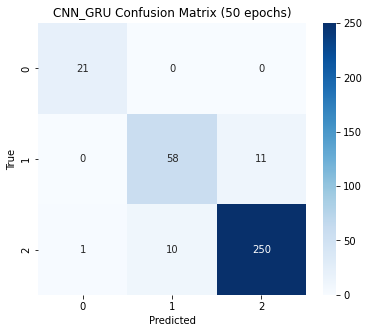


CNN_GRU Classification Report (50 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8529    0.8406    0.8467        69
           2     0.9579    0.9579    0.9579       261

    accuracy                         0.9373       351
   macro avg     0.9218    0.9328    0.9271       351
weighted avg     0.9370    0.9373    0.9371       351



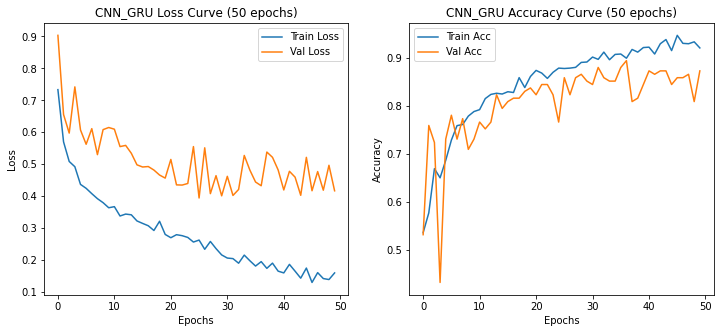

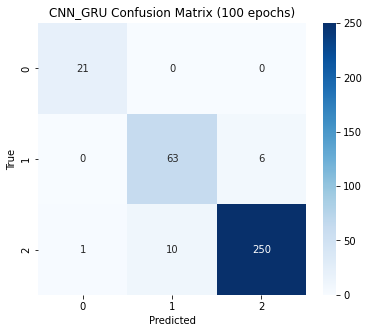


CNN_GRU Classification Report (100 epochs):

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8630    0.9130    0.8873        69
           2     0.9766    0.9579    0.9671       261

    accuracy                         0.9516       351
   macro avg     0.9314    0.9570    0.9437       351
weighted avg     0.9529    0.9516    0.9520       351



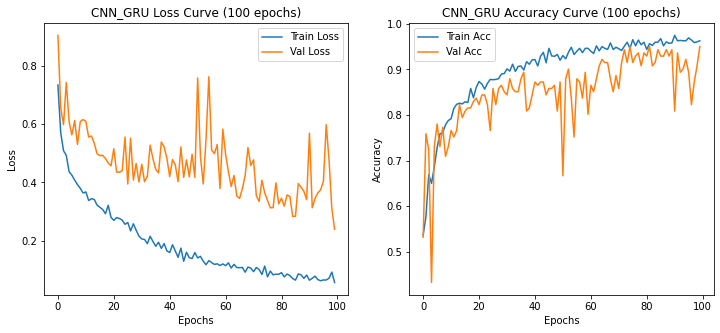

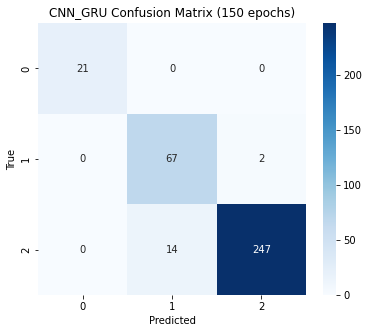


CNN_GRU Classification Report (150 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8272    0.9710    0.8933        69
           2     0.9920    0.9464    0.9686       261

    accuracy                         0.9544       351
   macro avg     0.9397    0.9725    0.9540       351
weighted avg     0.9601    0.9544    0.9557       351



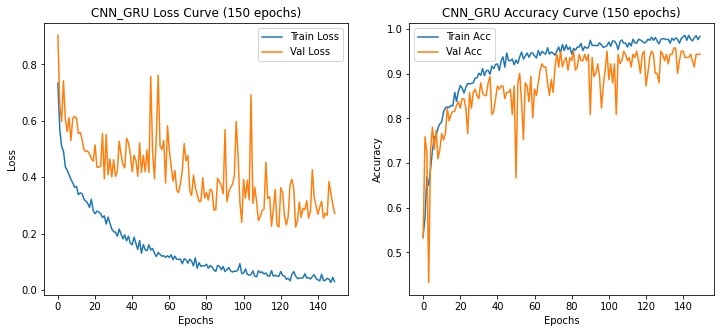

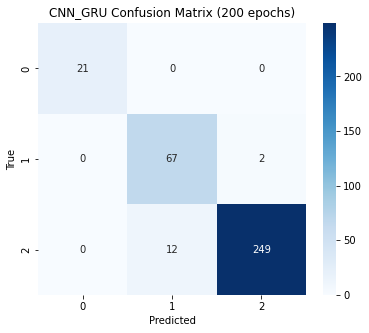


CNN_GRU Classification Report (200 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8481    0.9710    0.9054        69
           2     0.9920    0.9540    0.9727       261

    accuracy                         0.9601       351
   macro avg     0.9467    0.9750    0.9594       351
weighted avg     0.9642    0.9601    0.9611       351



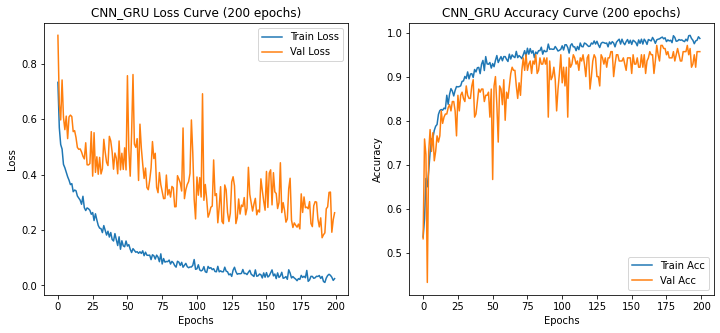

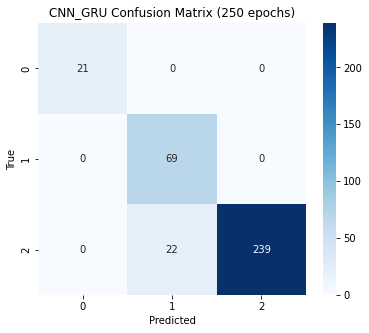


CNN_GRU Classification Report (250 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.7582    1.0000    0.8625        69
           2     1.0000    0.9157    0.9560       261

    accuracy                         0.9373       351
   macro avg     0.9194    0.9719    0.9395       351
weighted avg     0.9525    0.9373    0.9403       351



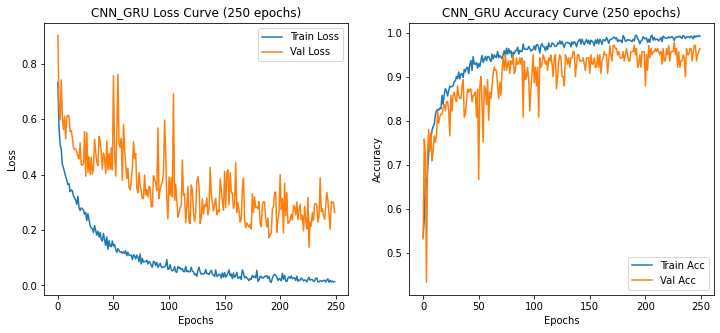

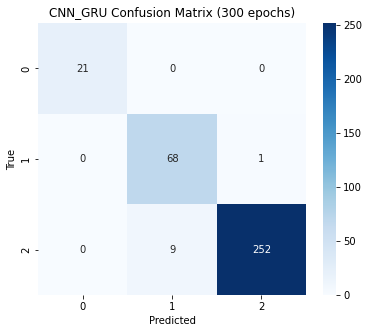


CNN_GRU Classification Report (300 epochs):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        21
           1     0.8831    0.9855    0.9315        69
           2     0.9960    0.9655    0.9805       261

    accuracy                         0.9715       351
   macro avg     0.9597    0.9837    0.9707       351
weighted avg     0.9741    0.9715    0.9721       351



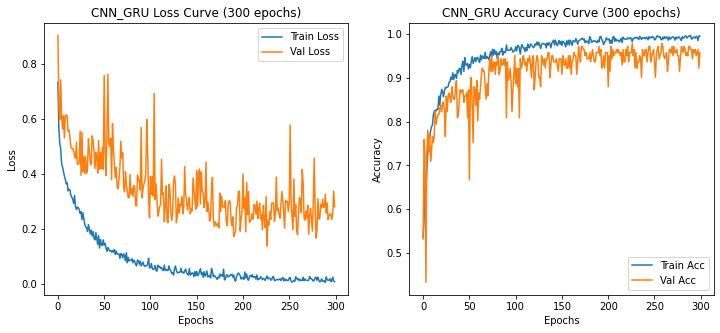

In [66]:
# Evaluate CNN+GRU model 50 epochs
evaluate_saved_model("cnn_gru", 50)
# Evaluate CNN+GRU model 100 epochs
evaluate_saved_model("cnn_gru", 100)
# Evaluate CNN+GRU model 150 epochs
evaluate_saved_model("cnn_gru", 150)
# Evaluate CNN+GRU model 200 epochs
evaluate_saved_model("cnn_gru", 200)
# Evaluate CNN+GRU model 250 epochs
evaluate_saved_model("cnn_gru", 250)
# Evaluate CNN+GRU model 300 epochs
evaluate_saved_model("cnn_gru", 300)

# 1. Ensemble Model : Soft Voting

In [67]:
from tensorflow.keras.models import load_model
# Load trained models
cnn_model = load_model("cnn_model_150epochs.h5")
lstm_model = load_model("lstm_model_200epochs.h5")
bi_lstm_model = load_model("bi_lstm_model_250epochs.h5")
gru_model = load_model("gru_model_150epochs.h5")

In [68]:
# Predict probabilities
cnn_pred = cnn_model.predict(x_test)
lstm_pred = lstm_model.predict(x_test)
bi_lstm_pred = bi_lstm_model.predict(x_test)
gru_pred = gru_model.predict(x_test)

In [69]:
# Soft voting: average of probabilities
ensemble_pred = (cnn_pred + lstm_pred + bi_lstm_pred + gru_pred) / 4
ensemble_classes = np.argmax(ensemble_pred, axis=1)

In [70]:
# True labels
y_true = np.argmax(y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, ensemble_classes)
f1  = f1_score(y_true, ensemble_classes, average='weighted')
rec = recall_score(y_true, ensemble_classes, average='weighted')
pre = precision_score(y_true, ensemble_classes, average='weighted')

In [71]:
# Print results
print("\nEnsemble Model (Soft Voting) Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")



Ensemble Model (Soft Voting) Performance:
--------------------------------------------------
Accuracy  : 0.9601
F1 Score  : 0.9600
Recall    : 0.9601
Precision : 0.9600
--------------------------------------------------


## 1. Ensemble(Soft voting):Confusion Matrix Classification Report

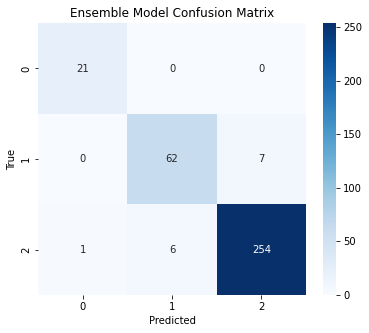


Ensemble Model Classification Report:

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.9118    0.8986    0.9051        69
           2     0.9732    0.9732    0.9732       261

    accuracy                         0.9601       351
   macro avg     0.9465    0.9572    0.9517       351
weighted avg     0.9600    0.9601    0.9600       351



In [72]:
# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nEnsemble Model Classification Report:\n")
print(classification_report(y_true, ensemble_classes, digits=4))

# 2. Ensemble Model : Hard Voting

In [73]:
from tensorflow.keras.models import load_model
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load trained models
cnn_model = load_model("cnn_model_150epochs.h5")
lstm_model = load_model("lstm_model_200epochs.h5")
bi_lstm_model = load_model("bi_lstm_model_250epochs.h5")
gru_model = load_model("gru_model_150epochs.h5")


In [74]:
# Predict class labels for each model
cnn_pred_classes = np.argmax(cnn_model.predict(x_test), axis=1)
lstm_pred_classes = np.argmax(lstm_model.predict(x_test), axis=1)
bi_lstm_pred_classes = np.argmax(bi_lstm_model.predict(x_test), axis=1)
gru_pred_classes = np.argmax(gru_model.predict(x_test), axis=1)

In [75]:
# Stack predictions and do Hard Voting
all_preds = np.stack([cnn_pred_classes, lstm_pred_classes, bi_lstm_pred_classes, gru_pred_classes], axis=1)
ensemble_classes = mode(all_preds, axis=1)[0].flatten()

# True labels
y_true = np.argmax(y_test, axis=1)

In [76]:
# Metrics
acc = accuracy_score(y_true, ensemble_classes)
f1  = f1_score(y_true, ensemble_classes, average='weighted')
rec = recall_score(y_true, ensemble_classes, average='weighted')
pre = precision_score(y_true, ensemble_classes, average='weighted')

In [77]:
# Print results
print("\nEnsemble Model (Hard Voting) Hard Voting Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")


Ensemble Model (Hard Voting) Hard Voting Performance:
--------------------------------------------------
Accuracy  : 0.9516
F1 Score  : 0.9524
Recall    : 0.9516
Precision : 0.9548
--------------------------------------------------


## 2. Ensemble(Hard voting):Confusion Matrix Classification Report

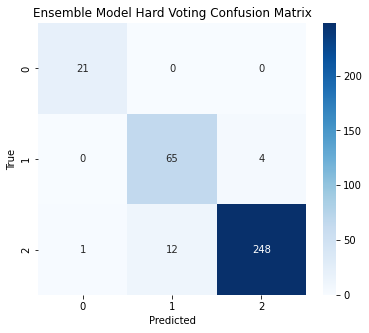

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Ensemble Model Hard Voting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [79]:
# Classification Report
print("\nEnsemble Model Hard Voting Classification Report:\n")
print(classification_report(y_true, ensemble_classes, digits=4))


Ensemble Model Hard Voting Classification Report:

              precision    recall  f1-score   support

           0     0.9545    1.0000    0.9767        21
           1     0.8442    0.9420    0.8904        69
           2     0.9841    0.9502    0.9669       261

    accuracy                         0.9516       351
   macro avg     0.9276    0.9641    0.9447       351
weighted avg     0.9548    0.9516    0.9524       351



# Machine Learning Model

## Function to generate Confusion Matrix & Classification Report

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def generate_ml_report(model_prefix, class_names=None):
    # Load predictions
    y_true = np.load(f"{model_prefix}_ytrue.npy")
    y_pred = np.load(f"{model_prefix}_ypred.npy")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_prefix.upper()} Confusion Matrix")
    plt.show()
    
    # Classification Report
    cr = classification_report(y_true, y_pred, target_names=class_names)
    print(f"\n{model_prefix.upper()} Classification Report:\n")
    print(cr)


### Data Preprocessing for Classic ML Models
#### Feature Flattening and Label Setup

In [81]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pickle
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ===== Flatten input for ML models =====
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat  = x_test.reshape(x_test.shape[0], -1)

# ===== Convert one-hot labels to integers =====
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels  = np.argmax(y_test, axis=1)


## 1. Logistic Regression Model

In [82]:
# ===== Logistic Regression =====
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='saga', random_state=42)
lr_model.fit(X_train_flat, y_train_labels)
y_pred = lr_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nLogistic Regression Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("lr_ytrue.npy", y_test_labels)
np.save("lr_ypred.npy", y_pred)
with open("lr_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



Logistic Regression Performance:
--------------------------------------------------
Accuracy  : 0.8234
F1 Score  : 0.7969
Recall    : 0.8234
Precision : 0.8031
--------------------------------------------------


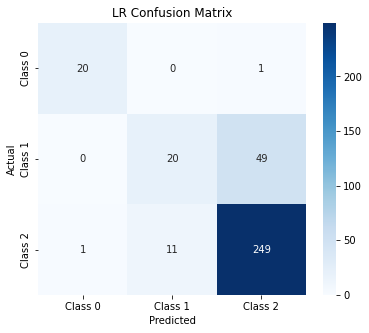


LR Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95        21
     Class 1       0.65      0.29      0.40        69
     Class 2       0.83      0.95      0.89       261

    accuracy                           0.82       351
   macro avg       0.81      0.73      0.75       351
weighted avg       0.80      0.82      0.80       351



In [83]:
# 1.Logistic Regression
generate_ml_report("lr", class_names=["Class 0", "Class 1", "Class 2"])

## 2. Support Vector Machine

In [84]:
# ===== Support Vector Machine =====
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_flat, y_train_labels)
y_pred = svm_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nSVM Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("svm_ytrue.npy", y_test_labels)
np.save("svm_ypred.npy", y_pred)
with open("svm_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



SVM Performance:
--------------------------------------------------
Accuracy  : 0.7721
F1 Score  : 0.6834
Recall    : 0.7721
Precision : 0.6290
--------------------------------------------------


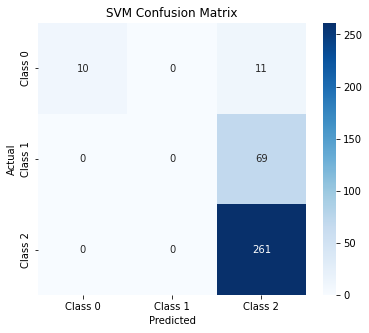


SVM Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.48      0.65        21
     Class 1       0.00      0.00      0.00        69
     Class 2       0.77      1.00      0.87       261

    accuracy                           0.77       351
   macro avg       0.59      0.49      0.50       351
weighted avg       0.63      0.77      0.68       351



In [85]:
# 2.SVM
generate_ml_report("svm", class_names=["Class 0", "Class 1", "Class 2"])

## 3. Random Forest

In [86]:
# ===== Random Forest =====
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_flat, y_train_labels)
y_pred = rf_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nRandom Forest Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("rf_ytrue.npy", y_test_labels)
np.save("rf_ypred.npy", y_pred)
with open("rf_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



Random Forest Performance:
--------------------------------------------------
Accuracy  : 0.9117
F1 Score  : 0.9073
Recall    : 0.9117
Precision : 0.9094
--------------------------------------------------


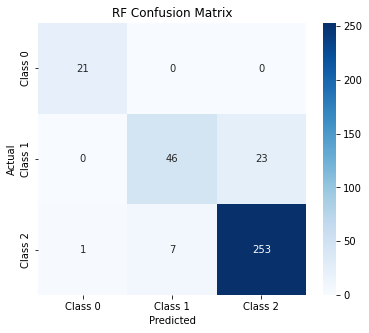


RF Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        21
     Class 1       0.87      0.67      0.75        69
     Class 2       0.92      0.97      0.94       261

    accuracy                           0.91       351
   macro avg       0.91      0.88      0.89       351
weighted avg       0.91      0.91      0.91       351



In [87]:
# 3.Random Forest
generate_ml_report("rf", class_names=["Class 0", "Class 1", "Class 2"])

## 4. K-Nearest Neighbors

In [88]:
# ===== K-Nearest Neighbors =====
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, y_train_labels)
y_pred = knn_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nKNN Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("knn_ytrue.npy", y_test_labels)
np.save("knn_ypred.npy", y_pred)
with open("knn_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



KNN Performance:
--------------------------------------------------
Accuracy  : 0.8205
F1 Score  : 0.8065
Recall    : 0.8205
Precision : 0.8040
--------------------------------------------------


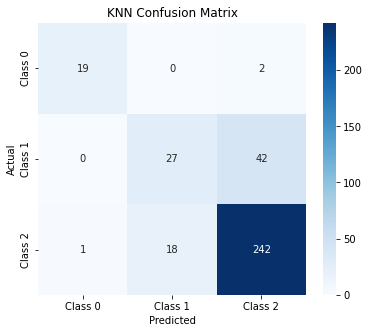


KNN Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.90      0.93        21
     Class 1       0.60      0.39      0.47        69
     Class 2       0.85      0.93      0.88       261

    accuracy                           0.82       351
   macro avg       0.80      0.74      0.76       351
weighted avg       0.80      0.82      0.81       351



In [89]:
# 4.KNN
generate_ml_report("knn", class_names=["Class 0", "Class 1", "Class 2"])

## 5. Gradient Boosting Machine (GBM)

In [90]:
# ===== Gradient Boosting Machine (GBM) =====
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
gbm_model.fit(X_train_flat, y_train_labels)
y_pred = gbm_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nGBM Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("gbm_ytrue.npy", y_test_labels)
np.save("gbm_ypred.npy", y_pred)
with open("gbm_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



GBM Performance:
--------------------------------------------------
Accuracy  : 0.9145
F1 Score  : 0.9118
Recall    : 0.9145
Precision : 0.9119
--------------------------------------------------


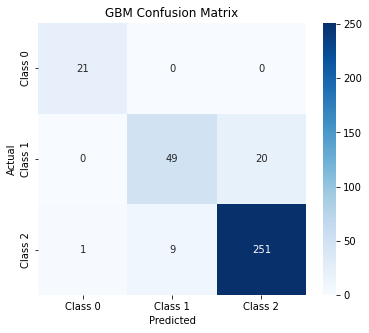


GBM Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        21
     Class 1       0.84      0.71      0.77        69
     Class 2       0.93      0.96      0.94       261

    accuracy                           0.91       351
   macro avg       0.91      0.89      0.90       351
weighted avg       0.91      0.91      0.91       351



In [91]:
# 5.GBM
generate_ml_report("gbm", class_names=["Class 0", "Class 1", "Class 2"])

## 6. XGBoost 

In [92]:
# ===== XGBoost =====
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_flat, y_train_labels)
y_pred = xgb_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nXGBoost Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("xgb_ytrue.npy", y_test_labels)
np.save("xgb_ypred.npy", y_pred)
with open("xgb_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



XGBoost Performance:
--------------------------------------------------
Accuracy  : 0.9430
F1 Score  : 0.9419
Recall    : 0.9430
Precision : 0.9425
--------------------------------------------------


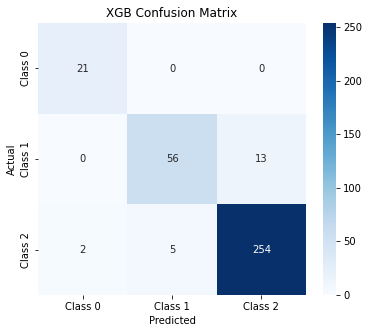


XGB Classification Report:

              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95        21
     Class 1       0.92      0.81      0.86        69
     Class 2       0.95      0.97      0.96       261

    accuracy                           0.94       351
   macro avg       0.93      0.93      0.93       351
weighted avg       0.94      0.94      0.94       351



In [93]:
# 6.XGBoost
generate_ml_report("xgb", class_names=["Class 0", "Class 1", "Class 2"])

## 7. LightGBM

In [94]:
# ===== LightGBM =====
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
lgb_model.fit(X_train_flat, y_train_labels)
y_pred = lgb_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nLightGBM Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("lgbm_ytrue.npy", y_test_labels)
np.save("lgbm_ypred.npy", y_pred)
with open("lgbm_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)



LightGBM Performance:
--------------------------------------------------
Accuracy  : 0.9402
F1 Score  : 0.9395
Recall    : 0.9402
Precision : 0.9400
--------------------------------------------------


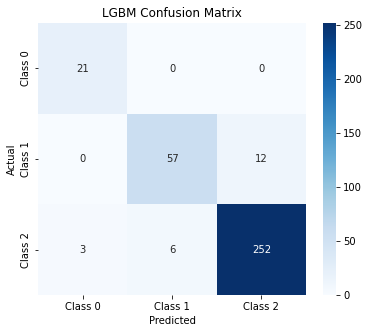


LGBM Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.93        21
     Class 1       0.90      0.83      0.86        69
     Class 2       0.95      0.97      0.96       261

    accuracy                           0.94       351
   macro avg       0.91      0.93      0.92       351
weighted avg       0.94      0.94      0.94       351



In [95]:
# 7.LightGBM
generate_ml_report("lgbm", class_names=["Class 0", "Class 1", "Class 2"])

## 8. Decision Tree

In [96]:
# ===== Decision Tree =====
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_flat, y_train_labels)
y_pred = dt_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nDecision Tree Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("dt_ytrue.npy", y_test_labels)
np.save("dt_ypred.npy", y_pred)
with open("dt_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)




Decision Tree Performance:
--------------------------------------------------
Accuracy  : 0.8462
F1 Score  : 0.8503
Recall    : 0.8462
Precision : 0.8581
--------------------------------------------------


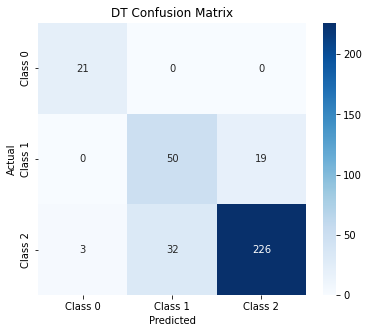


DT Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.93        21
     Class 1       0.61      0.72      0.66        69
     Class 2       0.92      0.87      0.89       261

    accuracy                           0.85       351
   macro avg       0.80      0.86      0.83       351
weighted avg       0.86      0.85      0.85       351



In [97]:
# 8.Decision Tree
generate_ml_report("dt", class_names=["Class 0", "Class 1", "Class 2"])

## 9. Naive Bayes

In [98]:
# ===== Naive Bayes =====
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_flat, y_train_labels)
y_pred = nb_model.predict(X_test_flat)

acc = accuracy_score(y_test_labels, y_pred)
f1  = f1_score(y_test_labels, y_pred, average='weighted')
rec = recall_score(y_test_labels, y_pred, average='weighted')
pre = precision_score(y_test_labels, y_pred, average='weighted')

print("\nNaive Bayes Performance:")
print(f"{'-'*50}")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"Precision : {pre:.4f}")
print(f"{'-'*50}")

np.save("nb_ytrue.npy", y_test_labels)
np.save("nb_ypred.npy", y_pred)
with open("nb_metrics.pkl", "wb") as f:
    pickle.dump({"accuracy": acc, "f1_score": f1, "recall": rec, "precision": pre}, f)


Naive Bayes Performance:
--------------------------------------------------
Accuracy  : 0.7550
F1 Score  : 0.7372
Recall    : 0.7550
Precision : 0.7452
--------------------------------------------------


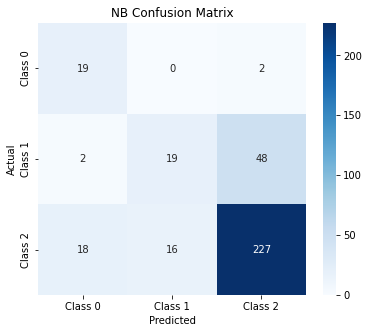


NB Classification Report:

              precision    recall  f1-score   support

     Class 0       0.49      0.90      0.63        21
     Class 1       0.54      0.28      0.37        69
     Class 2       0.82      0.87      0.84       261

    accuracy                           0.75       351
   macro avg       0.62      0.68      0.61       351
weighted avg       0.75      0.75      0.74       351



In [99]:
# 9.Naive Bayes
generate_ml_report("nb", class_names=["Class 0", "Class 1", "Class 2"])